# Comparison mass balance gradients of ML model, OGGM, PYGEM and GLOGEM

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde
import os
import glob

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from helpers import get_ytrue_y_pred_agg
from helpers import get_ytrue_y_pred_agg_season
from helpers import get_prediction_per_season_test

from model_classes import CustomXGBRegressor

#from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_season

Choose one glacier from each region \
Hansebreen, Tunsbergdalsbreen, Hellstugubreen and Langfjordjøkelen \
Compare mass balance gradient across models and add point observations where available


### Only Tunsbergdalsbreen

In [2]:
# Get file with glacier predictions
filepath = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'
#filepath = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-25_09-45-30/'

filename = 'pred_00434.csv' # Tunsbergdalsbreen
#filename = 'pred_01258.csv' # Langfjordjøkelen
#filename = 'pred_00449.csv' # Helstugubreen

df_pred = pd.read_csv(filepath+filename)

In [3]:
import pandas as pd
import numpy as np

df = df_pred

# Step 1: Round the minimum and maximum altitude values to the nearest 10 meters
min_altitude_rounded = np.floor(df['altitude'].min() / 10) * 10
max_altitude_rounded = np.ceil(df['altitude'].max() / 10) * 10

# Step 2: Create bins with 10-meter intervals
bins = np.arange(min_altitude_rounded, max_altitude_rounded + 10, 10)

# Step 3: Assign altitude intervals to the bins
df['altitude_interval'] = pd.cut(df['altitude'], bins=bins, right=False)

# Step 4: Name each interval by the mean (i.e. every whole 5 meters)
bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df['altitude_interval'].cat.categories}
df['altitude_interval'] = df['altitude_interval'].apply(lambda x: bin_centers[x])

# Step 5: Group by 'year' and 'altitude_interval', and calculate the mean of 'Ba_pred'
mean_Ba_by_year_and_elevation = df.groupby(['year', 'altitude_interval'])['Ba_pred'].mean().reset_index()

print(mean_Ba_by_year_and_elevation)


      year altitude_interval    Ba_pred
0     1960               525 -11.618050
1     1960               535 -10.808599
2     1960               545 -10.627678
3     1960               555 -10.412354
4     1960               565 -10.618963
...    ...               ...        ...
8737  2021              1885   0.124495
8738  2021              1895   0.242813
8739  2021              1905   0.512126
8740  2021              1915   0.422956
8741  2021              1925   0.352293

[8742 rows x 3 columns]


C:\Users\kasj\AppData\Local\Temp\ipykernel_10912\1773052026.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


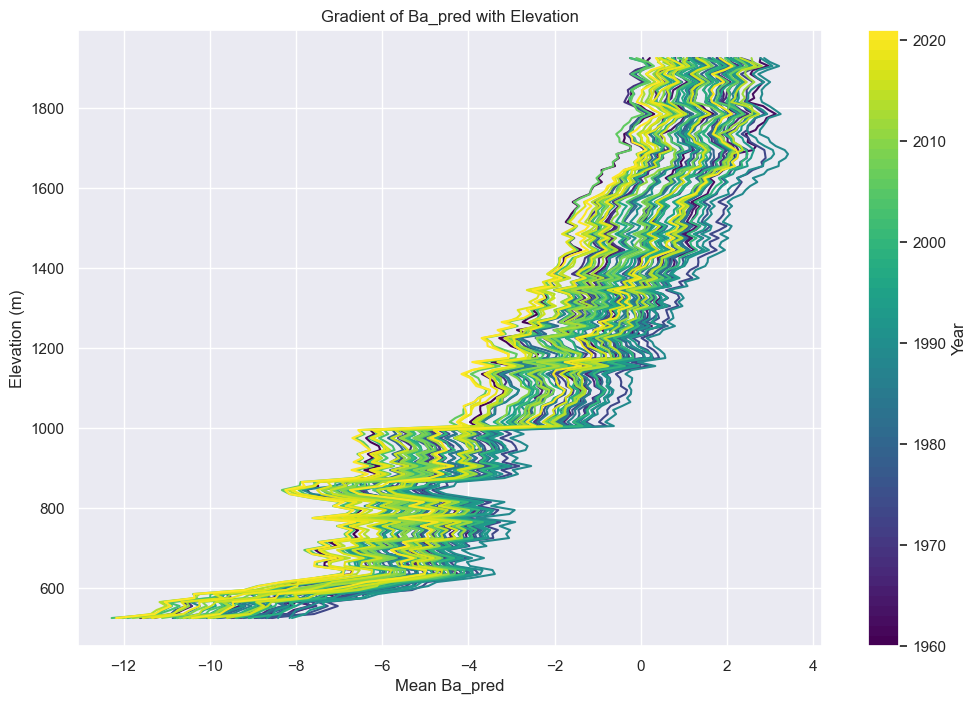

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn defaults are used for plots
#sns.set()

# Step 6: Plotting
plt.figure(figsize=(12, 8))

# Use the viridis colormap
cmap = plt.get_cmap("viridis", len(mean_Ba_by_year_and_elevation['year'].unique()))

# Plot each year with a different color
for i, (year, group) in enumerate(mean_Ba_by_year_and_elevation.groupby('year')):
    plt.plot(group['Ba_pred'], group['altitude_interval'], label=year, color=cmap(i))

# Add color bar to indicate the years
norm = plt.Normalize(mean_Ba_by_year_and_elevation['year'].min(), mean_Ba_by_year_and_elevation['year'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Year')
plt.legend().remove()

# Labels and title
plt.xlabel('Mean Ba_pred')
plt.ylabel('Elevation (m)')
plt.title('Gradient of Ba_pred with Elevation')

# Show legend
#plt.legend(title='Year')

# Show plot
plt.show()


C:\Users\kasj\AppData\Local\Temp\ipykernel_10912\4214187128.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


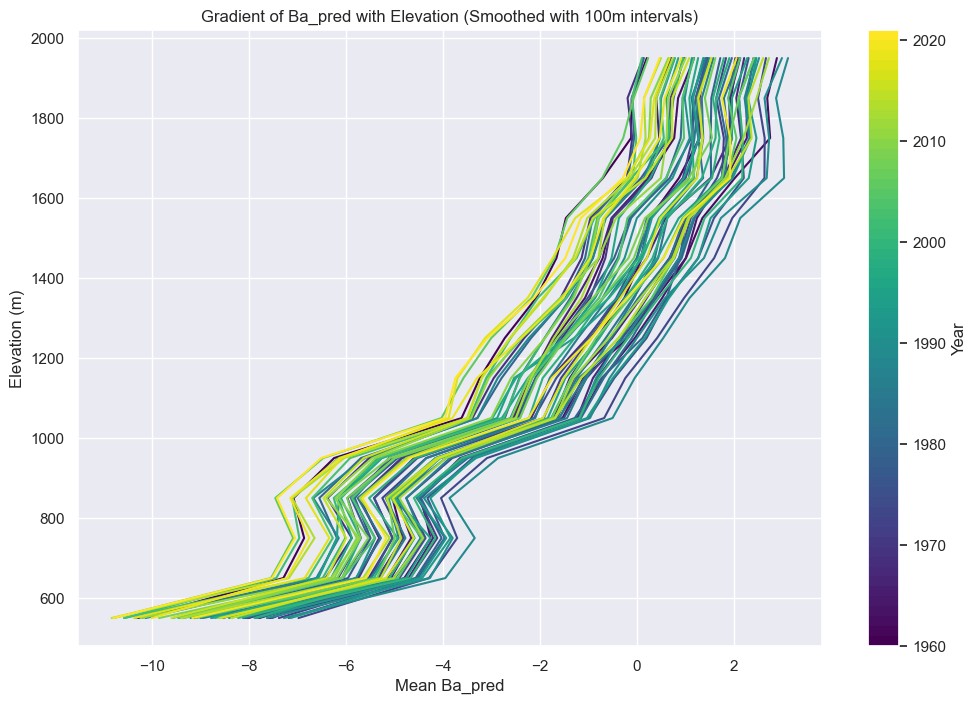

In [12]:

# Ensure seaborn defaults are used for plots
#sns.set()

df = df_pred.copy()

# Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
min_altitude_rounded = np.floor(df['altitude'].min() / 100) * 100
max_altitude_rounded = np.ceil(df['altitude'].max() / 100) * 100

# Step 2: Create bins with 100-meter intervals
bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

# Step 3: Assign altitude intervals to the bins
df['altitude_interval'] = pd.cut(df['altitude'], bins=bins, right=False)

# Step 4: Name each interval by the mean (i.e. every whole 50 meters)
bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df['altitude_interval'].cat.categories}
df['altitude_interval'] = df['altitude_interval'].apply(lambda x: bin_centers[x])

# Step 5: Group by 'year' and 'altitude_interval', and calculate the mean of 'Ba_pred'
mean_Ba_by_year_and_elevation = df.groupby(['year', 'altitude_interval'])['Ba_pred'].mean().reset_index()

# Step 6: Plotting
plt.figure(figsize=(12, 8))

# Use the viridis colormap
cmap = plt.get_cmap("viridis", len(mean_Ba_by_year_and_elevation['year'].unique()))

# Plot each year with a different color
for i, (year, group) in enumerate(mean_Ba_by_year_and_elevation.groupby('year')):
    plt.plot(group['Ba_pred'], group['altitude_interval'], label=year, color=cmap(i))

# Add color bar to indicate the years
norm = plt.Normalize(mean_Ba_by_year_and_elevation['year'].min(), mean_Ba_by_year_and_elevation['year'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Year')
plt.legend().remove()

# Labels and title
plt.xlabel('Mean Ba_pred')
plt.ylabel('Elevation (m)')
plt.title('Gradient of Ba_pred with Elevation (Smoothed with 100m intervals)')

# Show legend
#plt.legend(title='Year')

# Show plot
plt.show()


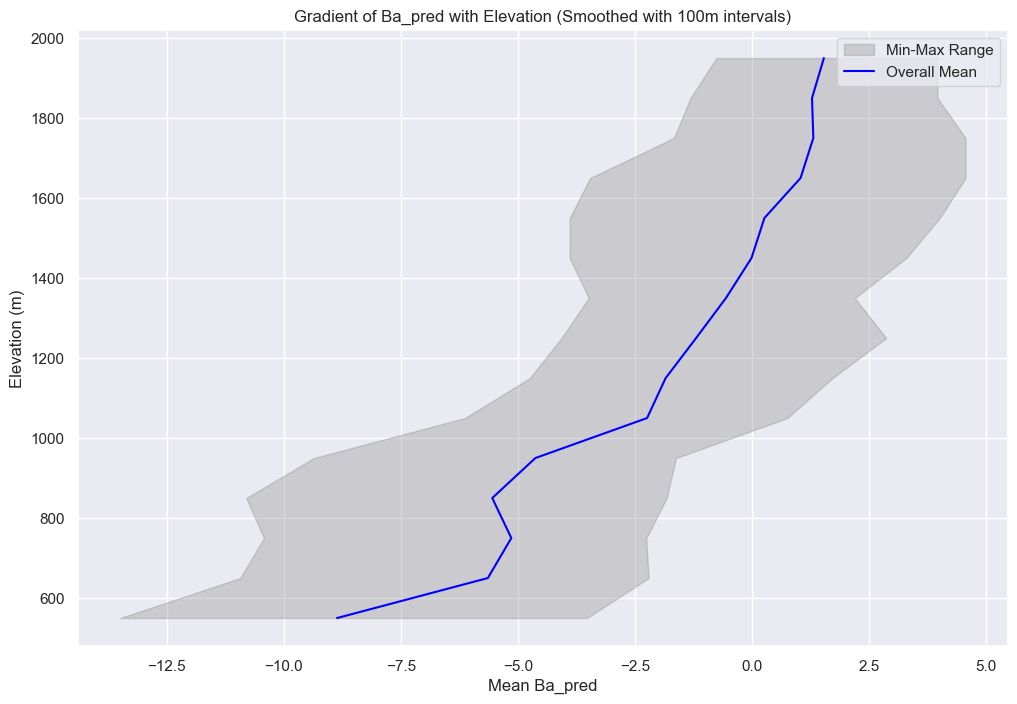

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn defaults are used for plots
#sns.set()

df=df_pred.copy()

# Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
min_altitude_rounded = np.floor(df['altitude'].min() / 100) * 100
max_altitude_rounded = np.ceil(df['altitude'].max() / 100) * 100

# Step 2: Create bins with 100-meter intervals
bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

# Step 3: Assign altitude intervals to the bins
df['altitude_interval'] = pd.cut(df['altitude'], bins=bins, right=False)

# Step 4: Name each interval by the mean (i.e. every whole 50 meters)
bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df['altitude_interval'].cat.categories}
df['altitude_interval'] = df['altitude_interval'].apply(lambda x: bin_centers[x])

# Step 5: Group by 'altitude_interval' and calculate the mean, min, and max of 'Ba_pred'
agg_Ba_by_elevation = df.groupby('altitude_interval').agg(
    mean_Ba=('Ba_pred', 'mean'),
    min_Ba=('Ba_pred', 'min'),
    max_Ba=('Ba_pred', 'max')
).reset_index()

# Step 6: Plotting
plt.figure(figsize=(12, 8))

# Plot shaded area between min and max Ba_pred
plt.fill_betweenx(agg_Ba_by_elevation['altitude_interval'],
                  agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                  color='gray', alpha=0.3, label='Min-Max Range')

# Plot mean gradient over all years
plt.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['altitude_interval'],
         label='Overall Mean', color='blue')

# Labels and title
plt.xlabel('Mean Ba_pred')
plt.ylabel('Elevation (m)')
plt.title('Gradient of Ba_pred with Elevation (Smoothed with 100m intervals)')
plt.legend()

# Show plot
plt.show()




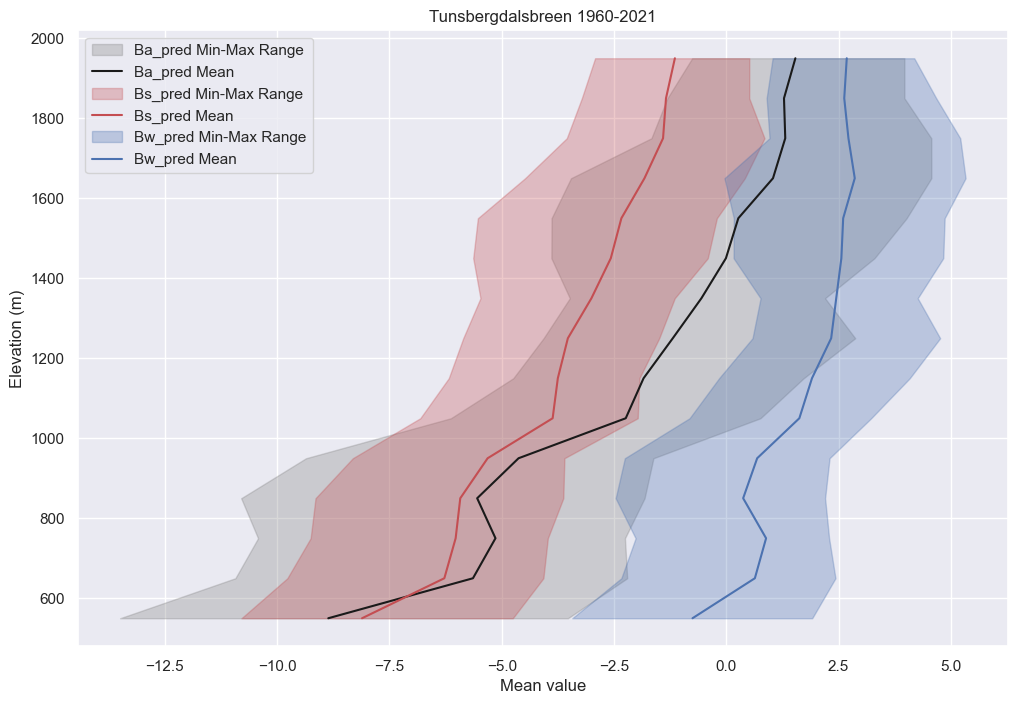

In [19]:

# Ensure seaborn defaults are used for plots
#sns.set()

df = df_pred.copy()

# Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
min_altitude_rounded = np.floor(df['altitude'].min() / 100) * 100
max_altitude_rounded = np.ceil(df['altitude'].max() / 100) * 100

# Step 2: Create bins with 100-meter intervals
bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

# Step 3: Assign altitude intervals to the bins
df['altitude_interval'] = pd.cut(df['altitude'], bins=bins, right=False)

# Step 4: Name each interval by the mean (i.e., every whole 50 meters)
bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df['altitude_interval'].cat.categories}
df['altitude_interval'] = df['altitude_interval'].apply(lambda x: bin_centers[x])

# Step 5: Group by 'altitude_interval' and calculate the mean, min, and max of 'Ba_pred', 'Bs_pred', and 'Bw_pred'
agg_Ba_by_elevation = df.groupby('altitude_interval').agg(
    mean_Ba=('Ba_pred', 'mean'),
    min_Ba=('Ba_pred', 'min'),
    max_Ba=('Ba_pred', 'max')
).reset_index()

agg_Bs_by_elevation = df.groupby('altitude_interval').agg(
    mean_Bs=('Bs_pred', 'mean'),
    min_Bs=('Bs_pred', 'min'),
    max_Bs=('Bs_pred', 'max')
).reset_index()

agg_Bw_by_elevation = df.groupby('altitude_interval').agg(
    mean_Bw=('Bw_pred', 'mean'),
    min_Bw=('Bw_pred', 'min'),
    max_Bw=('Bw_pred', 'max')
).reset_index()

# Step 6: Plotting
plt.figure(figsize=(12, 8))

# Plot shaded area and mean line for Ba_pred
plt.fill_betweenx(agg_Ba_by_elevation['altitude_interval'],
                  agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                  color='gray', alpha=0.3, label='Ba_pred Min-Max Range')
plt.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['altitude_interval'],
         label='Ba_pred Mean', color='k')

# Plot shaded area and mean line for Bs_pred
plt.fill_betweenx(agg_Bs_by_elevation['altitude_interval'],
                  agg_Bs_by_elevation['min_Bs'], agg_Bs_by_elevation['max_Bs'],
                  color='C3', alpha=0.3, label='Bs_pred Min-Max Range')
plt.plot(agg_Bs_by_elevation['mean_Bs'], agg_Bs_by_elevation['altitude_interval'],
         label='Bs_pred Mean', color='C3')

# Plot shaded area and mean line for Bw_pred
plt.fill_betweenx(agg_Bw_by_elevation['altitude_interval'],
                  agg_Bw_by_elevation['min_Bw'], agg_Bw_by_elevation['max_Bw'],
                  color='C0', alpha=0.3, label='Bw_pred Min-Max Range')
plt.plot(agg_Bw_by_elevation['mean_Bw'], agg_Bw_by_elevation['altitude_interval'],
         label='Bw_pred Mean', color='C0')

# Labels and title
plt.xlabel('Mass balance (m w.e.)')
plt.ylabel('Elevation (m)')
# Add title here: RGI60-08.XXXXX where XXXXX is the numbers from the filename.

plt.legend()

# Show plot
plt.show()


### All test glaciers, whole period

In [ ]:
#filename = 'pred_00434.csv' # Tunsbergdalsbreen
#filename = 'pred_01258.csv' # Langfjordjøkelen
#filename = 'pred_00449.csv' # Helstugubreen
#filename = 'pred_02650 # Ålfotbreen
# 02916 Bondhusbreen
# 01598 Svartisheibreen
# 02384 Rundvassbreen (blåmannsisen)

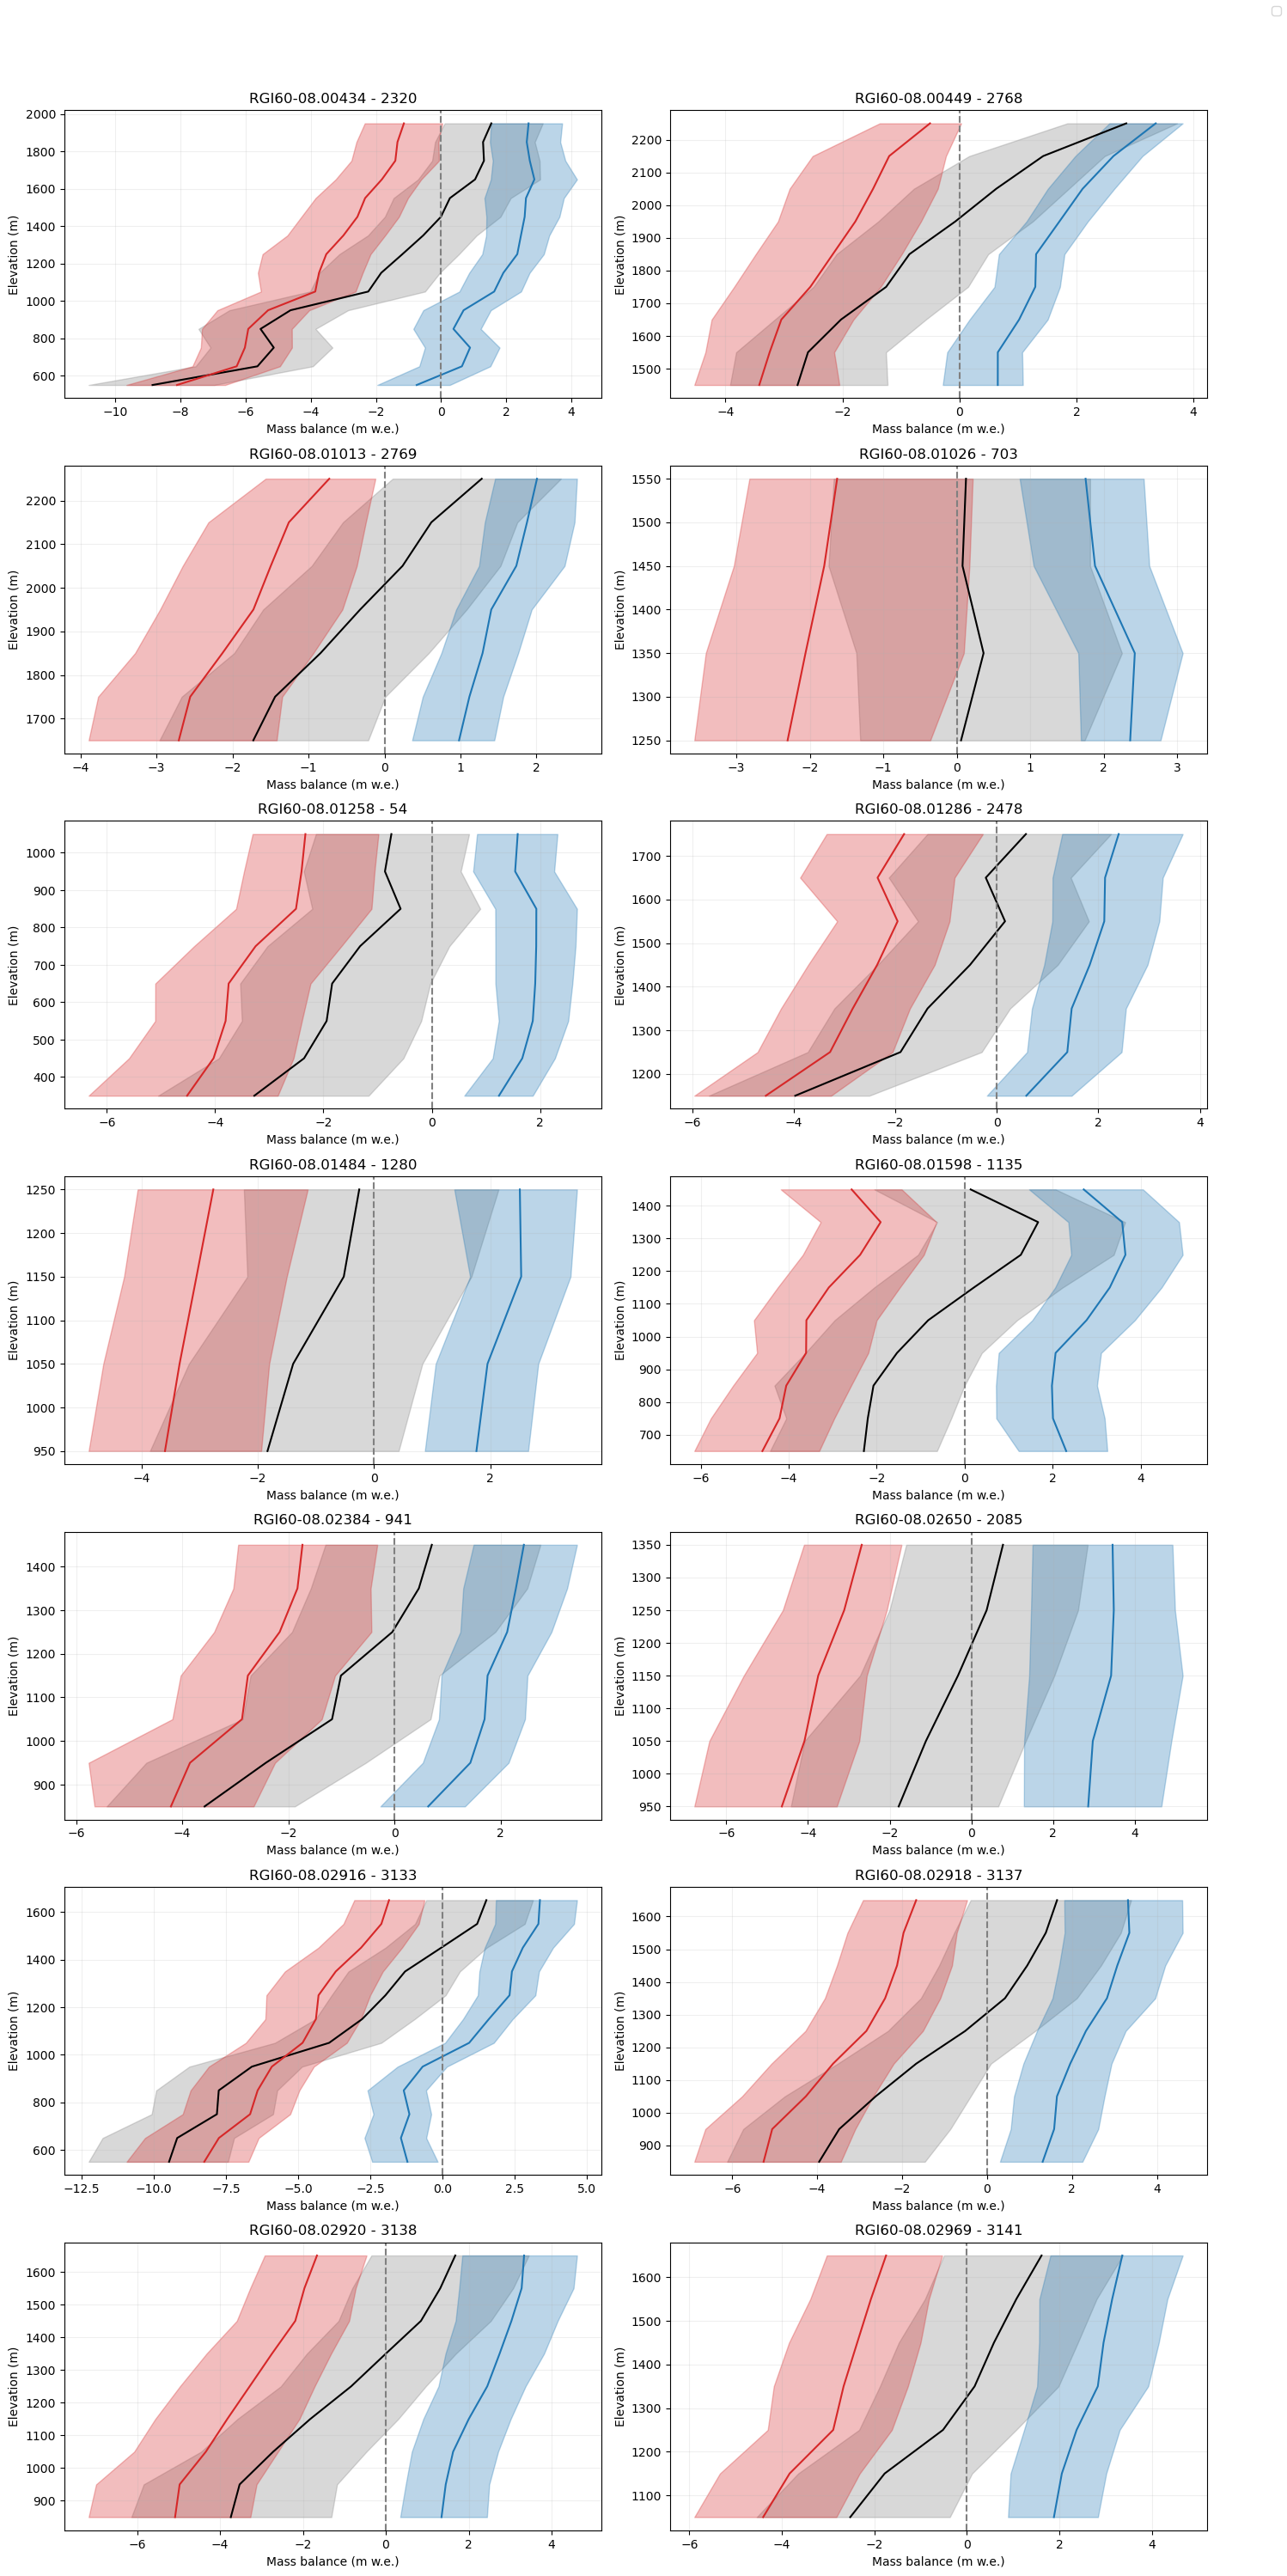

In [4]:
# Ensure seaborn defaults are used for plots
#sns.set()

# Path to the folder containing the CSV files
folder_path = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

# List of test glaciers to include
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

# Get a list of all CSV files in the folder
file_list = glob.glob(os.path.join(folder_path, '*.csv'))

# Filter the file_list to include only the files with the IDs in test_glaciers
filtered_file_list = [filename for filename in file_list if any(glacier_id in filename for glacier_id in test_glaciers)]

# Number of rows and columns for the subplots
nrows = 7
ncols = 2

# Create a figure with the specified number of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 30))
axes = axes.flatten()

for idx, filename in enumerate(filtered_file_list):
    if idx >= nrows * ncols:
        break  # Stop if we have more files than subplots

    # Read each CSV file into a DataFrame
    df_pred = pd.read_csv(filename)
    
    # Ensure the DataFrame contains the necessary columns
    required_columns = ['altitude', 'Ba_pred', 'Bs_pred', 'Bw_pred', 'year']
    if not all(column in df_pred.columns for column in required_columns):
        print(f"Skipping {filename} as it does not contain the required columns.")
        continue

    # Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
    min_altitude_rounded = np.floor(df_pred['altitude'].min() / 100) * 100
    max_altitude_rounded = np.ceil(df_pred['altitude'].max() / 100) * 100

    # Step 2: Create bins with 100-meter intervals
    bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

    # Step 3: Assign altitude intervals to the bins
    df_pred['altitude_interval'] = pd.cut(df_pred['altitude'], bins=bins, right=False)

    # Step 4: Name each interval by the mean (i.e., every whole 50 meters)
    bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df_pred['altitude_interval'].cat.categories}
    df_pred['altitude_interval'] = df_pred['altitude_interval'].apply(lambda x: bin_centers[x])

    # Step 5: Group by 'altitude_interval' and 'year' to calculate the mean values per year
    yearly_Ba_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Ba_pred.mean().reset_index()
    yearly_Bs_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bs_pred.mean().reset_index()
    yearly_Bw_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bw_pred.mean().reset_index()

    # Step 6: Now calculate the mean, min, and max of these yearly means for each altitude interval
    agg_Ba_by_elevation = yearly_Ba_by_elevation.groupby('altitude_interval').agg(
        mean_Ba=('Ba_pred', 'mean'),
        min_Ba=('Ba_pred', 'min'),
        max_Ba=('Ba_pred', 'max')
    ).reset_index()

    agg_Bs_by_elevation = yearly_Bs_by_elevation.groupby('altitude_interval').agg(
        mean_Bs=('Bs_pred', 'mean'),
        min_Bs=('Bs_pred', 'min'),
        max_Bs=('Bs_pred', 'max')
    ).reset_index()

    agg_Bw_by_elevation = yearly_Bw_by_elevation.groupby('altitude_interval').agg(
        mean_Bw=('Bw_pred', 'mean'),
        min_Bw=('Bw_pred', 'min'),
        max_Bw=('Bw_pred', 'max')
    ).reset_index()

    # Get the subplot axis
    ax = axes[idx]

    # Step 7: Plotting
    # Plot shaded area and mean line for Ba_pred
    ax.fill_betweenx(agg_Ba_by_elevation['altitude_interval'],
                     agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                     color='gray', alpha=0.3, label='Ba_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['altitude_interval'],
            label='Ba_pred Mean' if idx == 0 else "", color='k')

    # Plot shaded area and mean line for Bs_pred
    ax.fill_betweenx(agg_Bs_by_elevation['altitude_interval'],
                     agg_Bs_by_elevation['min_Bs'], agg_Bs_by_elevation['max_Bs'],
                     color='C3', alpha=0.3, label='Bs_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bs_by_elevation['mean_Bs'], agg_Bs_by_elevation['altitude_interval'],
            label='Bs_pred Mean' if idx == 0 else "", color='C3')

    # Plot shaded area and mean line for Bw_pred
    ax.fill_betweenx(agg_Bw_by_elevation['altitude_interval'],
                     agg_Bw_by_elevation['min_Bw'], agg_Bw_by_elevation['max_Bw'],
                     color='C0', alpha=0.3, label='Bw_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bw_by_elevation['mean_Bw'], agg_Bw_by_elevation['altitude_interval'],
            label='Bw_pred Mean' if idx == 0 else "", color='C0')

    glacier_name = df_pred['BREID'].iloc[0]

    ax.axvline(x=0, color='grey', linestyle='--')
    # Labels and title for this subplot
    ax.set_xlabel('Mass balance (m w.e.)')
    ax.set_ylabel('Elevation (m)')
    #ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]}")
    ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]} - {glacier_name}")
    ax.grid(alpha=0.2)
# Ensure legends show up
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 0.95, 0.97])
plt.show()


## Add other models

In [5]:
# Get mass balance predictions for OGGM, PYGEM, GLOGEM
filepath_models = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

fn_glogem_ann_seas_elev_band = 'GloGEM_annual_seasonal_mb_elev_band.nc'
fn_oggm_ann_seas_elev_band = 'OGGM_annual_seasonal_mb_elev_band.nc'
fn_pygem_ann_seas_elev_band = 'PyGEM_annual_seasonal_mb_elev_band.nc'

with xr.open_dataset(filepath_models + fn_glogem_ann_seas_elev_band) as ds_glogem:
    ds_glogem_ann_seas_elev_band = ds_glogem

with xr.open_dataset(filepath_models + fn_oggm_ann_seas_elev_band) as ds_oggm:
    ds_oggm_ann_seas_elev_band = ds_oggm

with xr.open_dataset(filepath_models + fn_pygem_ann_seas_elev_band) as ds_pygem:
    ds_pygem_ann_seas_elev_band = ds_pygem

In [6]:
ds_pygem_ann_seas_elev_band

<xarray.Dataset>
Dimensions:    (elevation: 226, time: 62, ID: 32)
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    PyGEM

In [7]:
# List of test glaciers to include (formatted to match the dataset)
test_glaciers = ['0434', '0449', '1013', '1026', '1258', '1286', '1484', '1598', '2384', '2650', '2916', '2918', '2920', '2969']

# Filter the dataset to include only the IDs in test_glaciers
ds_glogem_cropped = ds_glogem_ann_seas_elev_band.sel(ID=test_glaciers)
ds_oggm_cropped = ds_oggm_ann_seas_elev_band.sel(ID=test_glaciers)
ds_pygem_cropped = ds_pygem_ann_seas_elev_band.sel(ID=test_glaciers)

start_time = '1979-10-01'
end_time = '2019-09-30'

# Select the time slice from the dataset
ds_glogem_cropped = ds_glogem_cropped.sel(time=slice(start_time, end_time))
ds_oggm_cropped = ds_oggm_cropped.sel(time=slice(start_time, end_time))
ds_pygem_cropped = ds_pygem_cropped.sel(time=slice(start_time, end_time))

ds_glogem_mean = ds_glogem_cropped.mean(dim='time')
ds_oggm_mean = ds_oggm_cropped.mean(dim='time')
ds_pygem_mean = ds_pygem_cropped.mean(dim='time')
ds_pygem_mean['elevation']=ds_pygem_mean['elevation'].astype(int)


In [8]:
ds_pygem_mean

<xarray.Dataset>
Dimensions:    (elevation: 226, ID: 14)
Coordinates:
  * elevation  (elevation) int32 85 95 105 115 125 ... 2295 2305 2315 2325 2335
  * ID         (ID) object '0434' '0449' '1013' '1026' ... '2918' '2920' '2969'
Data variables:
    mb_annual  (ID, elevation) float64 nan nan nan nan nan ... nan nan nan nan
    mb_winter  (ID, elevation) float64 nan nan nan nan nan ... nan nan nan nan
    mb_summer  (ID, elevation) float64 nan nan nan nan nan ... nan nan nan nan

In [9]:

# Define the elevation bins (100m intervals)
elevation_bins = np.arange(0, 2400 + 100, 100)
bin_labels = (elevation_bins[:-1] + elevation_bins[1:]) / 2

# Convert the dataset to a Pandas DataFrame
df_glogem = ds_glogem_mean.to_dataframe().reset_index()
df_oggm = ds_oggm_mean.to_dataframe().reset_index()
df_pygem = ds_pygem_mean.to_dataframe().reset_index()

# Assign elevation intervals to the elevation bins
df_glogem['elevation_bins'] = pd.cut(df_glogem['elevation'], bins=elevation_bins, labels=bin_labels, right=False)
df_oggm['elevation_bins'] = pd.cut(df_oggm['elevation'], bins=elevation_bins, labels=bin_labels, right=False)
df_pygem['elevation_bins'] = pd.cut(df_pygem['elevation'], bins=elevation_bins, labels=bin_labels, right=False)

# Group by 'ID' and 'elevation_bins', and compute the mean
df_glogem_mean = df_glogem.groupby(['ID', 'elevation_bins']).mean().reset_index()
df_oggm_mean = df_oggm.groupby(['ID', 'elevation_bins']).mean().reset_index()
df_pygem_mean = df_pygem.groupby(['ID', 'elevation_bins']).mean().reset_index()



In [10]:
df_oggm

,elevation,ID,mb_annual,mb_winter,mb_summer,elevation_bins
0,25,0434,NaN,NaN,NaN,50.0
1,25,0449,NaN,NaN,NaN,50.0
2,25,1013,NaN,NaN,NaN,50.0
3,25,1026,NaN,NaN,NaN,50.0
4,25,1258,NaN,NaN,NaN,50.0
...,...,...,...,...,...,...
3313,2385,2650,NaN,NaN,NaN,2350.0
3314,2385,2916,NaN,NaN,NaN,2350.0
3315,2385,2918,NaN,NaN,NaN,2350.0
3316,2385,2920,NaN,NaN,NaN,2350.0


In [175]:
# Add point mass balances
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename_obs = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_svf.csv'

# Load data.
df_obs = pd.read_csv(filepath + filename_obs)

#df_obs = df_obs[df_obs['balance_winter'] != 9.99].reset_index(drop=True)
df_obs = df_obs.drop([3358,3359]).reset_index(drop=True)



C:\Users\kasj\AppData\Local\Temp\ipykernel_11640\4093486634.py:13: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(filepath + filename_obs)


In [176]:
df_obs[df_obs['balance_winter'] == 9.99]

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor


In [177]:
df_obs

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.005116,0.002688,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,0.778997
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001831,0.004597,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,0.798494
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.004949,0.003286,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,0.803510
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.002495,0.002263,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,0.803510
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.003314,0.004417,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,0.817480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4164,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.011964,0.007288,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,0.932281
4165,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.002572,0.000807,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,0.932281
4166,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008543,0.010311,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,0.932281
4167,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.008916,0.003751,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,0.932281


In [178]:
df_obs['elevation_bins'] = pd.cut(df_obs['altitude'], bins=elevation_bins, labels=bin_labels, right=False)
df_obs['year']=pd.to_datetime(df_obs['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
df_obs['year'] = df_obs.year.dt.year.astype('Int64')

In [179]:
df_obs

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,skyview_factor,elevation_bins,year
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919,0.778997,450.0,2013
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919,0.798494,450.0,2014
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919,0.803510,450.0,2015
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919,0.803510,450.0,2016
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919,0.817480,450.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4164,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759,0.932281,1050.0,2012
4165,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759,0.932281,1050.0,2013
4166,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759,0.932281,1050.0,2015
4167,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759,0.932281,1050.0,2016


In [180]:
df_obs = df_obs[(df_obs['year']>=1980) & (df_obs['year']<=2019)]


In [211]:
df_obs.loc[df_obs['BREID']==2768, ['balance_netto','balance_winter','balance_summer',
                                   'altitude','dt_curr_year_max_date']]

,balance_netto,balance_winter,balance_summer,altitude,dt_curr_year_max_date
3348,NaN,0.610,NaN,1648.0,05.05.2010 00:00
3349,-3.650,0.670,-4.320,1703.0,05.05.2011 00:00
3350,NaN,0.670,NaN,1904.0,05.05.2011 00:00
3351,0.060,1.030,-0.980,1904.0,13.05.2000 00:00
3352,-2.760,0.660,-3.420,1540.0,14.05.1999 00:00
3353,-2.170,0.440,-2.610,1540.0,11.05.2000 00:00
3354,NaN,0.710,NaN,1896.0,05.05.2011 00:00
3355,0.260,1.190,-0.930,1896.0,13.05.2000 00:00
3356,-1.100,1.030,-2.130,1964.0,05.05.2011 00:00
3357,0.780,1.420,-0.640,1954.0,13.05.2000 00:00


In [182]:

df_obs_mean = df_obs.groupby(['BREID','elevation_bins']).mean().reset_index()
df_obs_max = df_obs.groupby(['BREID','elevation_bins']).max().reset_index()
df_obs_min = df_obs.groupby(['BREID','elevation_bins']).min().reset_index()

# Merge the min and max values with the mean values
df_obs_mean['min_annual'] = df_obs_min['balance_netto']  
df_obs_mean['max_annual'] = df_obs_max['balance_netto']
df_obs_mean['min_winter'] = df_obs_min['balance_winter']  
df_obs_mean['max_winter'] = df_obs_max['balance_winter']
df_obs_mean['min_summer'] = df_obs_min['balance_summer']  
df_obs_mean['max_summer'] = df_obs_max['balance_summer']

C:\Users\kasj\AppData\Local\Temp\ipykernel_11640\2008587882.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_obs_mean = df_obs.groupby(['BREID','elevation_bins']).mean().reset_index()
C:\Users\kasj\AppData\Local\Temp\ipykernel_11640\2008587882.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  df_obs_max = df_obs.groupby(['BREID','elevation_bins']).max().reset_index()
C:\Users\kasj\AppData\Local\Temp\ipykernel_11640\2008587882.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the

In [183]:
df_obs_mean

,BREID,elevation_bins,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,altitude,utm_east,utm_north,balance_winter,...,tp_sep,altitude_climate,skyview_factor,year,min_annual,max_annual,min_winter,max_winter,min_summer,max_summer
0,54,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
1,54,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
2,54,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
3,54,350.0,34.0,529400.0,7780050.0,500.0,390.000000,530125.000000,7.780100e+06,NaN,...,0.003551,341.227919,0.694689,1993.0,-2.39,-2.39,NaN,NaN,NaN,NaN
4,54,450.0,34.0,529400.0,7780050.0,500.0,452.333333,529616.111111,7.780097e+06,1.156296,...,0.003899,341.227919,0.762165,2004.925926,-4.92,-2.39,0.6,1.77,-6.24,-3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,3141,1950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
548,3141,2050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
549,3141,2150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
550,3141,2250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
df_obs['ID'] = df_obs['RGIID'].str[-4:]
df_id = df_obs[['BREID', 'ID']]
breid_to_rgiid = df_id.set_index('BREID')['ID'].to_dict()

df_obs_mean['ID'] = df_obs_mean['BREID'].map(breid_to_rgiid)

df_obs_mean

C:\Users\kasj\AppData\Local\Temp\ipykernel_11640\1438316835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['ID'] = df_obs['RGIID'].str[-4:]


,BREID,elevation_bins,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,altitude,utm_east,utm_north,balance_winter,...,altitude_climate,skyview_factor,year,min_annual,max_annual,min_winter,max_winter,min_summer,max_summer,ID
0,54,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1258
1,54,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1258
2,54,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1258
3,54,350.0,34.0,529400.0,7780050.0,500.0,390.000000,530125.000000,7.780100e+06,NaN,...,341.227919,0.694689,1993.0,-2.39,-2.39,NaN,NaN,NaN,NaN,1258
4,54,450.0,34.0,529400.0,7780050.0,500.0,452.333333,529616.111111,7.780097e+06,1.156296,...,341.227919,0.762165,2004.925926,-4.92,-2.39,0.6,1.77,-6.24,-3.25,1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,3141,1950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,2969
548,3141,2050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,2969
549,3141,2150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,2969
550,3141,2250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,2969


In [185]:
from functools import reduce

# Rename the model columns to indicate the model name, for clarity
df_glogem_mean_r = df_glogem_mean.rename(columns={'mb_annual': 'mb_annual_glogem', 'mb_winter': 'mb_winter_glogem', 'mb_summer': 'mb_summer_glogem'})
df_oggm_mean_r = df_oggm_mean.rename(columns={'mb_annual': 'mb_annual_oggm', 'mb_winter': 'mb_winter_oggm', 'mb_summer': 'mb_summer_oggm'})
df_pygem_mean_r = df_pygem_mean.rename(columns={'mb_annual': 'mb_annual_pygem', 'mb_winter': 'mb_winter_pygem', 'mb_summer': 'mb_summer_pygem'})

df_obs_mean_r = df_obs_mean[['ID','elevation_bins', 'balance_netto','balance_summer','balance_winter']]

# List of all DataFrames to merge
dfs = [df_obs_mean, df_glogem_mean_r, df_oggm_mean_r, df_pygem_mean_r]

# Using reduce to merge all DataFrames on 'RGIID' and 'elevation_bins'
# Set the index to ['RGIID', 'elevation_bins']
df_obs_mean_r.set_index(['ID', 'elevation_bins'], inplace=True)
df_glogem_mean_r.set_index(['ID', 'elevation_bins'], inplace=True)
df_oggm_mean_r.set_index(['ID', 'elevation_bins'], inplace=True)
df_pygem_mean_r.set_index(['ID', 'elevation_bins'], inplace=True)

# Concatenate DataFrames along columns
df_obs_mod = pd.concat([df_obs_mean_r, df_glogem_mean_r, df_oggm_mean_r, df_pygem_mean_r], axis=1)

# Reset the index to turn multi-index into columns again
df_obs_mod.reset_index(inplace=True)

In [186]:
df_obs_mean.ID.unique()

array(['1258', '2458', '2384', '0287', '1657', '1598', '1484', '2666',
       '2650', '2017', '1126', '1286', '1217', '0868', '0987', '0449',
       '1779', '2963', '2962', '2916', '2918', '2920', '2969'],
      dtype=object)

In [188]:
df_obs_mod

,ID,elevation_bins,balance_netto,balance_summer,balance_winter,elevation,mb_annual_glogem,mb_winter_glogem,mb_summer_glogem,elevation,mb_annual_oggm,mb_winter_oggm,mb_summer_oggm,elevation,mb_annual_pygem,mb_winter_pygem,mb_summer_pygem
0,1258,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,90.0,NaN,NaN,NaN
1,1258,150.0,NaN,NaN,NaN,170.0,NaN,NaN,NaN,150.0,NaN,NaN,NaN,150.0,NaN,NaN,NaN
2,1258,250.0,NaN,NaN,NaN,250.0,NaN,NaN,NaN,250.0,NaN,NaN,NaN,250.0,NaN,NaN,NaN
3,1258,350.0,-2.390000,NaN,NaN,350.0,NaN,NaN,NaN,350.0,-2.964504,1.692673,-4.657177,350.0,-3.380564,1.603559,-4.984123
4,1258,450.0,-3.341538,-4.501538,1.156296,450.0,-2.598594,1.299167,-3.897761,450.0,-2.418187,1.696767,-4.114954,450.0,-2.711587,1.702048,-4.413635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,1026,1950.0,NaN,NaN,NaN,1950.0,NaN,NaN,NaN,1950.0,NaN,NaN,NaN,1950.0,NaN,NaN,NaN
620,1026,2050.0,NaN,NaN,NaN,2050.0,NaN,NaN,NaN,2050.0,NaN,NaN,NaN,2050.0,NaN,NaN,NaN
621,1026,2150.0,NaN,NaN,NaN,2150.0,NaN,NaN,NaN,2150.0,NaN,NaN,NaN,2150.0,NaN,NaN,NaN
622,1026,2250.0,NaN,NaN,NaN,2250.0,NaN,NaN,NaN,2250.0,NaN,NaN,NaN,2250.0,NaN,NaN,NaN


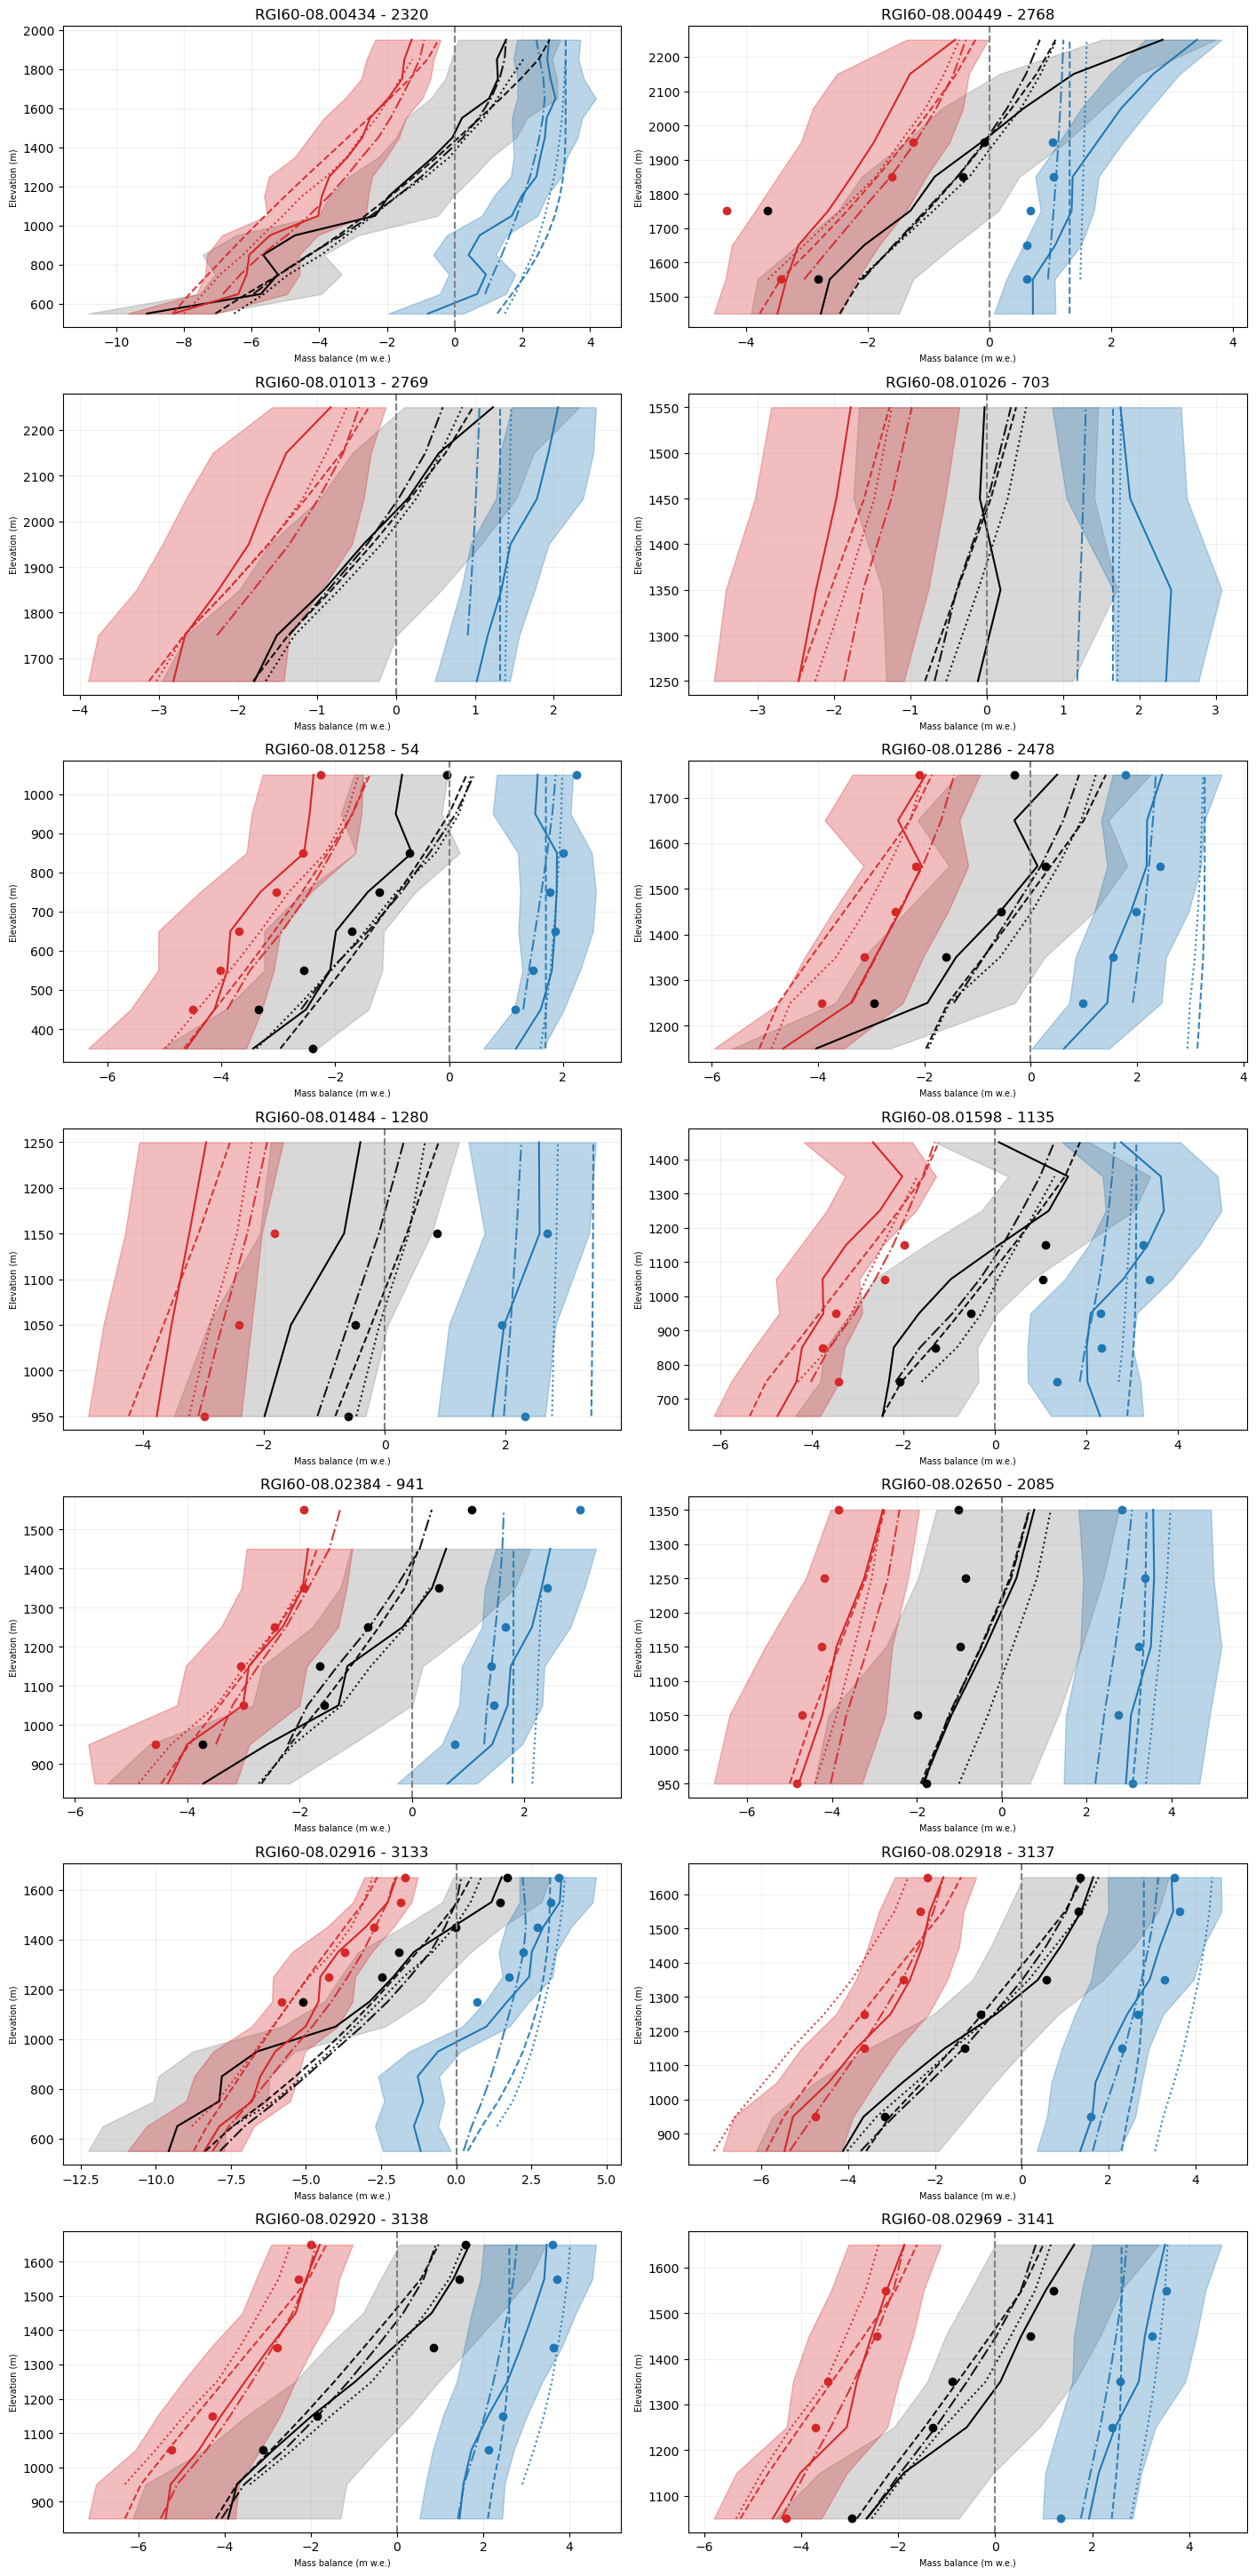

In [189]:
# Ensure seaborn defaults are used for plots
#sns.set()
start_year = 1980
end_year = 2019

# Path to the folder containing the CSV files
folder_path = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

# List of test glaciers to include
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

# Get a list of all CSV files in the folder
file_list = glob.glob(os.path.join(folder_path, '*.csv'))

# Filter the file_list to include only the files with the IDs in test_glaciers
filtered_file_list = [filename for filename in file_list if any(glacier_id in filename for glacier_id in test_glaciers)]

# DataFrame to store results
columns = ['ID', 'elevation_bins', 'mb_annual_ml', 'mb_summer_ml', 'mb_winter_ml']
results_df = pd.DataFrame(columns=columns)

# Number of rows and columns for the subplots
nrows = 7
ncols = 2

cm=1/2.54
fontsize=7

# Create a figure with the specified number of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 30))
axes = axes.flatten()

for idx, filename in enumerate(filtered_file_list):
    if idx >= nrows * ncols:
        break  # Stop if we have more files than subplots

    # Read each CSV file into a DataFrame
    df_pred = pd.read_csv(filename)
    df_pred = df_pred[(df_pred['year']>=start_year) & (df_pred['year']<=end_year)]
    
    # Ensure the DataFrame contains the necessary columns
    required_columns = ['altitude', 'Ba_pred', 'Bs_pred', 'Bw_pred', 'year']
    if not all(column in df_pred.columns for column in required_columns):
        print(f"Skipping {filename} as it does not contain the required columns.")
        continue

    # Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
    min_altitude_rounded = np.floor(df_pred['altitude'].min() / 100) * 100
    max_altitude_rounded = np.ceil(df_pred['altitude'].max() / 100) * 100

    # Step 2: Create bins with 100-meter intervals
    bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

    # Step 3: Assign altitude intervals to the bins
    df_pred['elevation_bins'] = pd.cut(df_pred['altitude'], bins=bins, right=False)

    # Step 4: Name each interval by the mean (i.e., every whole 50 meters)
    bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df_pred['elevation_bins'].cat.categories}
    df_pred['elevation_bins'] = df_pred['elevation_bins'].apply(lambda x: bin_centers[x])

    # Step 5: Group by 'altitude_interval' and 'year' to calculate the mean values per year
    yearly_Ba_by_elevation = df_pred.groupby(['elevation_bins', 'year']).Ba_pred.mean().reset_index()
    yearly_Bs_by_elevation = df_pred.groupby(['elevation_bins', 'year']).Bs_pred.mean().reset_index()
    yearly_Bw_by_elevation = df_pred.groupby(['elevation_bins', 'year']).Bw_pred.mean().reset_index()

    # Step 6: Now calculate the mean, min, and max of these yearly means for each altitude interval
    agg_Ba_by_elevation = yearly_Ba_by_elevation.groupby('elevation_bins').agg(
        mean_Ba=('Ba_pred', 'mean'),
        min_Ba=('Ba_pred', 'min'),
        max_Ba=('Ba_pred', 'max')
    ).reset_index()

    agg_Bs_by_elevation = yearly_Bs_by_elevation.groupby('elevation_bins').agg(
        mean_Bs=('Bs_pred', 'mean'),
        min_Bs=('Bs_pred', 'min'),
        max_Bs=('Bs_pred', 'max')
    ).reset_index()

    agg_Bw_by_elevation = yearly_Bw_by_elevation.groupby('elevation_bins').agg(
        mean_Bw=('Bw_pred', 'mean'),
        min_Bw=('Bw_pred', 'min'),
        max_Bw=('Bw_pred', 'max')
    ).reset_index()

    # Get the subplot axis
    ax = axes[idx]

    # Step 7: Plotting
    # Plot shaded area and mean line for Ba_pred
    ax.fill_betweenx(agg_Ba_by_elevation['elevation_bins'],
                     agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                     color='gray', alpha=0.3, label='Ba_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['elevation_bins'],
            label='Ba_pred Mean' if idx == 0 else "", color='k')

    # Plot shaded area and mean line for Bs_pred
    ax.fill_betweenx(agg_Bs_by_elevation['elevation_bins'],
                     agg_Bs_by_elevation['min_Bs'], agg_Bs_by_elevation['max_Bs'],
                     color='C3', alpha=0.3, label='Bs_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bs_by_elevation['mean_Bs'], agg_Bs_by_elevation['elevation_bins'],
            label='Bs_pred Mean' if idx == 0 else "", color='C3')

    # Plot shaded area and mean line for Bw_pred
    ax.fill_betweenx(agg_Bw_by_elevation['elevation_bins'],
                     agg_Bw_by_elevation['min_Bw'], agg_Bw_by_elevation['max_Bw'],
                     color='C0', alpha=0.3, label='Bw_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bw_by_elevation['mean_Bw'], agg_Bw_by_elevation['elevation_bins'],
            label='Bw_pred Mean' if idx == 0 else "", color='C0')

    glacier_id = df_pred['RGIID'].iloc[0][-4:]

    # Add the results to the results_df
    #for index, row in agg_Ba_by_elevation.iterrows():
    #    elevation_bin = row['elevation_bins']
    #    mean_Ba = row['mean_Ba']
    #    mean_Bs = agg_Bs_by_elevation.loc[agg_Bs_by_elevation['elevation_bins'] == elevation_bin, 'mean_Bs'].values[0]
    #    mean_Bw = agg_Bw_by_elevation.loc[agg_Bw_by_elevation['elevation_bins'] == elevation_bin, 'mean_Bw'].values[0]
    #    results_df = results_df.append({'ID': glacier_id, 'elevation_bins': elevation_bin, 
    #                                    'mb_annual_ml': mean_Ba, 'mb_summer_ml': mean_Bs, 
    #                                    'mb_winter_ml': mean_Bw}, ignore_index=True)

    # Add the results to the results_df
    temp_df = pd.DataFrame({
        'ID': [glacier_id] * len(agg_Ba_by_elevation),
        'elevation_bins': agg_Ba_by_elevation['elevation_bins'],
        'mb_annual_ml': agg_Ba_by_elevation['mean_Ba'],
        'mb_summer_ml': agg_Bs_by_elevation['mean_Bs'],
        'mb_winter_ml': agg_Bw_by_elevation['mean_Bw']
    })

    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    

    glacier_df_glogem = df_glogem_mean[df_glogem_mean['ID'] == glacier_id]
    glacier_df_oggm = df_oggm_mean[df_oggm_mean['ID'] == glacier_id]
    glacier_df_pygem = df_pygem_mean[df_pygem_mean['ID'] == glacier_id]

    # Plot the mean mass balance values
    # Diamond/dashdot for GloGEM
    # Square/dashed for OGGM
    # Circle/dotted for PyGEM
    alpha=0.9
    ax.plot(glacier_df_glogem['mb_annual'], glacier_df_glogem['elevation_bins'].astype(float), label='Annual Mass Balance', 
            linestyle='-.',color='k', alpha=alpha)#marker='D', 
    ax.plot(glacier_df_glogem['mb_winter'], glacier_df_glogem['elevation_bins'].astype(float), label='Winter Mass Balance', 
            linestyle='-.', color='C0',alpha=alpha)
    ax.plot(glacier_df_glogem['mb_summer'], glacier_df_glogem['elevation_bins'].astype(float), label='Summer Mass Balance', 
            linestyle='-.', color='C3',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_annual'], glacier_df_oggm['elevation_bins'].astype(float), label='Annual Mass Balance', 
            linestyle='--', color='k',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_winter'], glacier_df_oggm['elevation_bins'].astype(float), label='Winter Mass Balance', 
            linestyle='--', color='C0',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_summer'], glacier_df_oggm['elevation_bins'].astype(float), label='Summer Mass Balance', 
            linestyle='--', color='C3',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_annual'], glacier_df_pygem['elevation_bins'].astype(float), label='Annual Mass Balance', 
            linestyle=':', color='k',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_winter'], glacier_df_pygem['elevation_bins'].astype(float), label='Winter Mass Balance', 
            linestyle=':', color='C0',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_summer'], glacier_df_pygem['elevation_bins'].astype(float), label='Summer Mass Balance', 
            linestyle=':', color='C3',alpha=alpha)
           
    glacier_name = df_pred['BREID'].iloc[0]

    # Add point mass balance observations
    glacier_obs = df_obs_mean[df_obs_mean['BREID']==glacier_name]
    ax.scatter(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], marker='o', color='k')
    ax.scatter(glacier_obs['balance_winter'], glacier_obs['elevation_bins'], marker='o', color='C0')
    ax.scatter(glacier_obs['balance_summer'], glacier_obs['elevation_bins'], marker='o', color='C3')

    #ann_err = [glacier_obs['balance_netto'] - glacier_obs['min_annual'], glacier_obs['max_annual'] - glacier_obs['balance_netto']]
    #ax.errorbar(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], xerr=ann_err, fmt='.', lw=2, capsize=3, alpha=0.7, zorder=0)
    
    ax.axvline(x=0, color='grey', linestyle='--')
    # Labels and title for this subplot
    ax.set_xlabel('Mass balance (m w.e.)', fontsize=fontsize)
    ax.set_ylabel('Elevation (m)',fontsize=fontsize)
    
    #ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]}")
    ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]} - {glacier_name}")
    ax.grid(alpha=0.2)
# Ensure legends show up
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 0.95, 0.97])
plt.show()


In [190]:
# Ensure 'ID' column exists in combined_df and is of the same type
results_df['ID'] = results_df['ID'].astype(str)
results_df['elevation_bins'] = results_df['elevation_bins'].astype(float)
results_df

,ID,elevation_bins,mb_annual_ml,mb_summer_ml,mb_winter_ml
0,0434,550.0,-9.094497,-8.307120,-0.787377
1,0434,650.0,-5.724734,-6.387518,0.662784
2,0434,750.0,-5.221409,-6.144784,0.923375
3,0434,850.0,-5.656679,-6.067126,0.410447
4,0434,950.0,-4.717274,-5.454694,0.737420
...,...,...,...,...,...
107,2969,1250.0,-0.586391,-3.061621,2.475231
108,2969,1350.0,0.108070,-2.853062,2.961132
109,2969,1450.0,0.536268,-2.551305,3.087573
110,2969,1550.0,1.042416,-2.236970,3.279386


In [191]:
# Merge results_df with combined_df using the 'ID' column
df_obs_mod_all = pd.merge(df_obs_mod, results_df, on=['ID', 'elevation_bins'], how='left')

In [196]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def bias(y_true, y_pred):
    return np.mean(y_pred - y_true)


In [197]:
# List of all relevant columns (observations and model predictions)
observation_cols = ['balance_netto', 'balance_summer', 'balance_winter']
model_prefixes = ['mb_annual', 'mb_summer', 'mb_winter']
models = ['glogem', 'oggm', 'pygem', 'ml']

# Create a list of all columns to check for NaNs
all_columns = observation_cols + [f'{prefix}_{model}' for model in models for prefix in model_prefixes]

# Drop rows where any of these columns have NaN values
clean_df = df_obs_mod_all.dropna(subset=all_columns)

# Check the cleaned data
print(clean_df.head())



     ID  elevation_bins  balance_netto  balance_summer  balance_winter  \
4  1258           450.0      -3.341538       -4.501538        1.156296   
5  1258           550.0      -2.550000       -4.021000        1.473000   
6  1258           650.0      -1.705000       -3.697586        1.861379   
7  1258           750.0      -1.233333       -3.043000        1.772000   
8  1258           850.0      -0.692308       -2.575882        2.000286   

   elevation  mb_annual_glogem  mb_winter_glogem  mb_summer_glogem  elevation  \
4      450.0         -2.598594          1.299167         -3.897761      450.0   
5      550.0         -2.095605          1.399662         -3.495267      550.0   
6      650.0         -1.422508          1.509100         -2.931608      650.0   
7      750.0         -0.836272          1.619108         -2.455379      750.0   
8      850.0         -0.345951          1.721731         -2.067682      850.0   

   mb_annual_oggm  mb_winter_oggm  mb_summer_oggm  elevation  mb_ann

In [205]:
clean_df

,ID,elevation_bins,balance_netto,balance_summer,balance_winter,elevation,mb_annual_glogem,mb_winter_glogem,mb_summer_glogem,elevation,mb_annual_oggm,mb_winter_oggm,mb_summer_oggm,elevation,mb_annual_pygem,mb_winter_pygem,mb_summer_pygem,mb_annual_ml,mb_summer_ml,mb_winter_ml
4,1258,450.0,-3.341538,-4.501538,1.156296,450.0,-2.598594,1.299167,-3.897761,450.0,-2.418187,1.696767,-4.114954,450.0,-2.711587,1.702048,-4.413635,-2.512170,-4.120485,1.608315
5,1258,550.0,-2.550000,-4.021000,1.473000,550.0,-2.095605,1.399662,-3.495267,550.0,-1.881984,1.698051,-3.580035,550.0,-2.070165,1.777722,-3.847887,-2.090494,-3.895505,1.805011
6,1258,650.0,-1.705000,-3.697586,1.861379,650.0,-1.422508,1.509100,-2.931608,650.0,-1.370985,1.698051,-3.069036,650.0,-1.476116,1.836247,-3.312363,-1.987892,-3.841729,1.853837
7,1258,750.0,-1.233333,-3.043000,1.772000,750.0,-0.836272,1.619108,-2.455379,750.0,-0.885464,1.698051,-2.583515,750.0,-0.928181,1.887409,-2.815591,-1.429254,-3.316134,1.886880
8,1258,850.0,-0.692308,-2.575882,2.000286,850.0,-0.345951,1.721731,-2.067682,850.0,-0.429396,1.698051,-2.127447,850.0,-0.236754,1.935456,-2.172210,-0.655193,-2.548061,1.892868
10,1258,1050.0,-0.037551,-2.261163,2.229302,1050.0,0.438978,1.870209,-1.431231,1050.0,0.306601,1.698051,-1.391450,1050.0,0.391488,1.982789,-1.591301,-0.826791,-2.381501,1.554710
57,2384,950.0,-3.725000,-4.568333,0.754286,950.0,-2.208650,1.281803,-3.490453,950.0,-2.169144,1.796069,-3.965213,950.0,-2.112708,2.178216,-4.290923,-2.578363,-4.003199,1.424836
58,2384,1050.0,-1.563571,-3.007857,1.448571,1050.0,-1.859946,1.334762,-3.194708,1050.0,-1.619008,1.801857,-3.420865,1050.0,-1.253855,2.223859,-3.477714,-1.309120,-3.008453,1.699333
59,2384,1150.0,-1.650000,-3.053077,1.406154,1150.0,-1.329000,1.411908,-2.740908,1150.0,-1.089908,1.804077,-2.893985,1150.0,-0.734660,2.246021,-2.980680,-1.151495,-2.905957,1.754462
60,2384,1250.0,-0.791000,-2.450000,1.661000,1250.0,-0.759538,1.484172,-2.243710,1250.0,-0.591812,1.804141,-2.395952,1250.0,-0.123406,2.276067,-2.399473,-0.169313,-2.302963,2.133649


In [202]:
# Prepare a dictionary to store the results
# Prepare a dictionary to store the results
results = {metric: {balance_type: {model: np.nan for model in models} for balance_type in model_prefixes} for metric in ['RMSE', 'MAE', 'R2', 'Bias']}

for model in models:
    for balance, obs_col in zip(model_prefixes, observation_cols):
        model_col = f'{balance}_{model}'
        
        # Ensure valid columns exist in the cleaned DataFrame
        if obs_col in clean_df.columns and model_col in clean_df.columns:
            y_true = clean_df[obs_col]
            y_pred = clean_df[model_col]
            
            # Calculate metrics
            results['RMSE'][balance][model] = rmse(y_true, y_pred)
            results['MAE'][balance][model] = mae(y_true, y_pred)
            results['R2'][balance][model] = r2(y_true, y_pred)
            results['Bias'][balance][model] = bias(y_true, y_pred)

# Print results with rounding to 2 decimal places, organized by balance type
for balance_type in model_prefixes:
    balance_name = balance_type.split('_')[-1].capitalize()
    print(f'\n{balance_name} Results:')
    for metric in ['RMSE', 'MAE', 'R2', 'Bias']:
        print(f'\n{metric}:')
        for model in models:
            value = results[metric][balance_type][model]
            print(f'{model}: {value:.2f}')



Annual Results:

RMSE:
glogem: 0.90
oggm: 0.86
pygem: 0.92
ml: 0.83

MAE:
glogem: 0.66
oggm: 0.63
pygem: 0.69
ml: 0.61

R2:
glogem: 0.68
oggm: 0.71
pygem: 0.66
ml: 0.72

Bias:
glogem: 0.14
oggm: 0.14
pygem: 0.45
ml: 0.08

Summer Results:

RMSE:
glogem: 0.65
oggm: 0.73
pygem: 0.72
ml: 0.60

MAE:
glogem: 0.47
oggm: 0.59
pygem: 0.58
ml: 0.44

R2:
glogem: 0.61
oggm: 0.51
pygem: 0.52
ml: 0.67

Bias:
glogem: 0.35
oggm: -0.18
pygem: -0.25
ml: -0.00

Winter Results:

RMSE:
glogem: 0.56
oggm: 0.84
pygem: 0.91
ml: 0.40

MAE:
glogem: 0.45
oggm: 0.66
pygem: 0.75
ml: 0.33

R2:
glogem: 0.60
oggm: 0.11
pygem: -0.05
ml: 0.79

Bias:
glogem: -0.20
oggm: 0.33
pygem: 0.70
ml: 0.09


In [218]:
# Prepare a dictionary to store the results
results = {metric: {balance_type: {model: np.nan for model in models} for balance_type in model_prefixes} for metric in ['RMSE', 'MAE', 'R2', 'Bias']}

for model in models:
    for balance, obs_col in zip(model_prefixes, observation_cols):
        model_col = f'{balance}_{model}'
        
        # Ensure valid columns exist in the cleaned DataFrame
        if obs_col in clean_df.columns and model_col in clean_df.columns:
            y_true = clean_df[obs_col]
            y_pred = clean_df[model_col]
            
            # Calculate metrics
            results['RMSE'][balance][model] = rmse(y_true, y_pred)
            results['MAE'][balance][model] = mae(y_true, y_pred)
            results['R2'][balance][model] = r2(y_true, y_pred)
            results['Bias'][balance][model] = bias(y_true, y_pred)


In [219]:
# Consolidate results into a single DataFrame
combined_results = []

for balance in model_prefixes:
    balance_name = balance.split('_')[-1].capitalize()
    for model in models:
        row = {
            'Balance Type': balance_name,
            'Model': model.capitalize(),
            'RMSE': results['RMSE'][balance][model],
            'MAE': results['MAE'][balance][model],
            'R2': results['R2'][balance][model],
            'Bias': results['Bias'][balance][model]
        }
        combined_results.append(row)

results_latex = pd.DataFrame(combined_results)

# Round the metrics to 2 decimal places
results_latex = results_latex.round(2)



In [220]:
# Convert DataFrame to LaTeX table
latex_table = results_latex.to_latex(index=False, caption='Metrics for each model and balance type', label='tab:metrics', escape=False)

# Print the LaTeX table
print(latex_table)


\begin{table}
\centering
\caption{Metrics for each model and balance type}
\label{tab:metrics}
\begin{tabular}{llrrrr}
\toprule
Balance Type &  Model &  RMSE &  MAE &    R2 &  Bias \\
\midrule
      Annual & Glogem &  0.90 & 0.66 &  0.68 &  0.14 \\
      Annual &   Oggm &  0.86 & 0.63 &  0.71 &  0.14 \\
      Annual &  Pygem &  0.92 & 0.69 &  0.66 &  0.45 \\
      Annual &     Ml &  0.83 & 0.61 &  0.72 &  0.08 \\
      Summer & Glogem &  0.65 & 0.47 &  0.61 &  0.35 \\
      Summer &   Oggm &  0.73 & 0.59 &  0.51 & -0.18 \\
      Summer &  Pygem &  0.72 & 0.58 &  0.52 & -0.25 \\
      Summer &     Ml &  0.60 & 0.44 &  0.67 & -0.00 \\
      Winter & Glogem &  0.56 & 0.45 &  0.60 & -0.20 \\
      Winter &   Oggm &  0.84 & 0.66 &  0.11 &  0.33 \\
      Winter &  Pygem &  0.91 & 0.75 & -0.05 &  0.70 \\
      Winter &     Ml &  0.40 & 0.33 &  0.79 &  0.09 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\kasj\AppData\Local\Temp\ipykernel_11640\2619051893.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = results_latex.to_latex(index=False, caption='Metrics for each model and balance type', label='tab:metrics', escape=False)


In [151]:
# Selected glaciers in different regions:
# 2478 (west), 54 (north), 941 (north)
# 2085 (west-mar), 3137 (west), 2768 (east)
# 8 breer: 1 w-mar, 1 east, 2 west, 2 north
# Antall obs i test dataset i perioden 1980-2019
# 54 has 180 points - THIS
# 703 has 0 points
# 941 has 71 points - THIS
# 1135 has 56 points
# 1280 has 23 points
# 2320 has 0 points
# 2478 has 89 points - THIS
# 2769 has 0 points
# 2768 has 14 points - THIS
# 3133 has 26 points
# 3137 has 65 points - THIS
# 3138 has 6 points
# 3141 has 72 points
# 2085 has 150 points - THIS
# Glaciers have between 65 and 180 measured stake locations over the time period, except for 2768 (14)
# which is the only glacier in the continental/east region

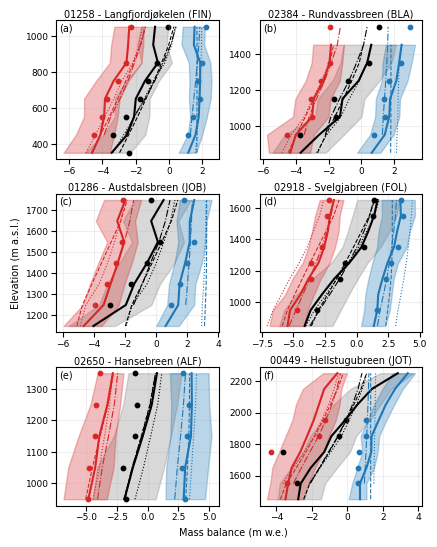

In [27]:
# In the order of test_glaciers

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

start_year = 1980
end_year = 2019

# Path to the folder containing the CSV files
folder_path = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

# List of test glaciers to include
# [north, north, west, west, west-mar, east]
test_glaciers = ['01258', '02384', '01286', '02918', '02650', '00449']
#test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

names = ['Langfjordjøkelen (FIN)', 'Rundvassbreen (BLA)', 'Austdalsbreen (JOB)', 'Svelgjabreen (FOL)', 'Hansebreen (ALF)', 'Hellstugubreen (JOT)']

subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Get a list of all CSV files in the folder
file_list = glob.glob(os.path.join(folder_path, '*.csv'))

# Create a dictionary to map glacier ids to filenames
glacier_file_dict = {}
for filename in file_list:
    for glacier_id in test_glaciers:
        if glacier_id in filename:
            glacier_file_dict[glacier_id] = filename
            break

# Sort the filenames according to the order in test_glaciers
sorted_file_list = [glacier_file_dict[glacier_id] for glacier_id in test_glaciers if glacier_id in glacier_file_dict]

# Number of rows and columns for the subplots
nrows = 3
ncols = 2

cm=1/2.54
fontsize=7

# Create a figure with the specified number of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*cm, 16*cm))
axes = axes.flatten()

for idx, filename in enumerate(sorted_file_list):
    if idx >= nrows * ncols:
        break  # Stop if we have more files than subplots

    # Read each CSV file into a DataFrame
    df_pred = pd.read_csv(filename)
    df_pred = df_pred[(df_pred['year']>=start_year) & (df_pred['year']<=end_year)]
    
    # Ensure the DataFrame contains the necessary columns
    required_columns = ['altitude', 'Ba_pred', 'Bs_pred', 'Bw_pred', 'year']
    if not all(column in df_pred.columns for column in required_columns):
        print(f"Skipping {filename} as it does not contain the required columns.")
        continue

    # Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
    min_altitude_rounded = np.floor(df_pred['altitude'].min() / 100) * 100
    max_altitude_rounded = np.ceil(df_pred['altitude'].max() / 100) * 100

    # Step 2: Create bins with 100-meter intervals
    bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

    # Step 3: Assign altitude intervals to the bins
    df_pred['altitude_interval'] = pd.cut(df_pred['altitude'], bins=bins, right=False)

    # Step 4: Name each interval by the mean (i.e., every whole 50 meters)
    bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df_pred['altitude_interval'].cat.categories}
    df_pred['altitude_interval'] = df_pred['altitude_interval'].apply(lambda x: bin_centers[x])

    # Step 5: Group by 'altitude_interval' and 'year' to calculate the mean values per year
    yearly_Ba_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Ba_pred.mean().reset_index()
    yearly_Bs_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bs_pred.mean().reset_index()
    yearly_Bw_by_elevation = df_pred.groupby(['altitude_interval', 'year']).Bw_pred.mean().reset_index()

    # Step 6: Now calculate the mean, min, and max of these yearly means for each altitude interval
    agg_Ba_by_elevation = yearly_Ba_by_elevation.groupby('altitude_interval').agg(
        mean_Ba=('Ba_pred', 'mean'),
        min_Ba=('Ba_pred', 'min'),
        max_Ba=('Ba_pred', 'max')
    ).reset_index()

    agg_Bs_by_elevation = yearly_Bs_by_elevation.groupby('altitude_interval').agg(
        mean_Bs=('Bs_pred', 'mean'),
        min_Bs=('Bs_pred', 'min'),
        max_Bs=('Bs_pred', 'max')
    ).reset_index()

    agg_Bw_by_elevation = yearly_Bw_by_elevation.groupby('altitude_interval').agg(
        mean_Bw=('Bw_pred', 'mean'),
        min_Bw=('Bw_pred', 'min'),
        max_Bw=('Bw_pred', 'max')
    ).reset_index()

    # Get the subplot axis
    ax = axes[idx]

    # Step 7: Plotting
    # Plot shaded area and mean line for Ba_pred
    ax.fill_betweenx(agg_Ba_by_elevation['altitude_interval'],
                     agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
                     color='gray', alpha=0.3, label='Ba_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['altitude_interval'],
            label='Ba_pred Mean' if idx == 0 else "", color='k')

    # Plot shaded area and mean line for Bs_pred
    ax.fill_betweenx(agg_Bs_by_elevation['altitude_interval'],
                     agg_Bs_by_elevation['min_Bs'], agg_Bs_by_elevation['max_Bs'],
                     color='C3', alpha=0.3, label='Bs_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bs_by_elevation['mean_Bs'], agg_Bs_by_elevation['altitude_interval'],
            label='Bs_pred Mean' if idx == 0 else "", color='C3')

    # Plot shaded area and mean line for Bw_pred
    ax.fill_betweenx(agg_Bw_by_elevation['altitude_interval'],
                     agg_Bw_by_elevation['min_Bw'], agg_Bw_by_elevation['max_Bw'],
                     color='C0', alpha=0.3, label='Bw_pred Min-Max Range' if idx == 0 else "")
    ax.plot(agg_Bw_by_elevation['mean_Bw'], agg_Bw_by_elevation['altitude_interval'],
            label='Bw_pred Mean' if idx == 0 else "", color='C0')

    glacier_id = df_pred['RGIID'].iloc[0][-4:]

    glacier_df_glogem = df_glogem_mean[df_glogem_mean['ID'] == glacier_id]
    glacier_df_oggm = df_oggm_mean[df_oggm_mean['ID'] == glacier_id]
    glacier_df_pygem = df_pygem_mean[df_pygem_mean['ID'] == glacier_id]

    # Plot the mean mass balance values
    # Diamond/dashdot for GloGEM
    # Square/dashed for OGGM
    # Circle/dotted for PyGEM
    alpha=1
    lw=0.8
    ax.plot(glacier_df_glogem['mb_annual'], glacier_df_glogem['elevation_bins'].astype(float), label='Annual Mass Balance', lw=lw, linestyle='-.',color='k', alpha=alpha)#marker='D', 
    ax.plot(glacier_df_glogem['mb_winter'], glacier_df_glogem['elevation_bins'].astype(float), label='Winter Mass Balance', lw=lw, linestyle='-.', color='C0',alpha=alpha)
    ax.plot(glacier_df_glogem['mb_summer'], glacier_df_glogem['elevation_bins'].astype(float), label='Summer Mass Balance', lw=lw, linestyle='-.', color='C3',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_annual'], glacier_df_oggm['elevation_bins'].astype(float), label='Annual Mass Balance', lw=lw, linestyle='--', color='k',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_winter'], glacier_df_oggm['elevation_bins'].astype(float), label='Winter Mass Balance', lw=lw, linestyle='--', color='C0',alpha=alpha)
    ax.plot(glacier_df_oggm['mb_summer'], glacier_df_oggm['elevation_bins'].astype(float), label='Summer Mass Balance', lw=lw, linestyle='--', color='C3',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_annual'], glacier_df_pygem['elevation_bins'].astype(float), label='Annual Mass Balance', lw=lw, linestyle=':', color='k',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_winter'], glacier_df_pygem['elevation_bins'].astype(float), label='Winter Mass Balance', lw=lw, linestyle=':', color='C0',alpha=alpha)
    ax.plot(glacier_df_pygem['mb_summer'], glacier_df_pygem['elevation_bins'].astype(float), label='Summer Mass Balance', lw=lw, linestyle=':', color='C3',alpha=alpha)
           
    glacier_name = df_pred['BREID'].iloc[0]

    # Add point mass balance observations
    glacier_obs = df_obs_mean[df_obs_mean['BREID']==glacier_name]
    ax.scatter(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], marker='o', color='k', s=10)
    ax.scatter(glacier_obs['balance_winter'], glacier_obs['elevation_bins'], marker='o', color='C0', s=10)
    ax.scatter(glacier_obs['balance_summer'], glacier_obs['elevation_bins'], marker='o', color='C3', s=10)

    #ann_err = [glacier_obs['balance_netto'] - glacier_obs['min_annual'], glacier_obs['max_annual'] - glacier_obs['balance_netto']]
    #ax.errorbar(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], xerr=ann_err, fmt='.', lw=2, capsize=3, alpha=0.7, zorder=0)
    
    #ax.axvline(x=0, color='grey', linestyle='--')

    # Add subplot label
    ax.text(0.02, 0.98, subplot_labels[idx], transform=ax.transAxes, fontsize=fontsize, verticalalignment='top', horizontalalignment='left')
    
    #ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]}")
    ax.set_title(f"{os.path.basename(filename).split('_')[1].split('.')[0]} - {names[idx]}", fontsize=fontsize, pad=2)
    #ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]} - {glacier_name}", fontsize=fontsize)
    ax.grid(alpha=0.2)
    ax.tick_params(labelsize=6.5, pad=2)
    ax.set_ylabel('')
    ax.set_xlabel('')

#axes[4].set_xlabel('Mass balance (m w.e.)', fontsize=fontsize)
#axes[5].set_xlabel('Mass balance (m w.e.)', fontsize=fontsize)

#axes[0].set_ylabel('Elevation (m)',fontsize=fontsize)
axes[2].set_ylabel('Elevation (m a.s.l.)',fontsize=fontsize)
#axes[4].set_ylabel('Elevation (m)',fontsize=fontsize)
fig.supxlabel('Mass balance (m w.e.)', fontsize=fontsize, y=0.06)
# Ensure legends show up
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')

# Adjust the layout
plt.subplots_adjust(hspace=0.25, wspace=0.25)
#plt.tight_layout(rect=[0, 0, 0.95, 0.97])

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'smb_gradients.pdf', format='pdf', bbox_inches='tight')

plt.show()


## Compute elevation-band metrics for XGBoost model 1962-2021

In [48]:
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename_obs = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_svf.csv'

df_obs = pd.read_csv(filepath + filename_obs)

# Drop erroneous values
df_obs = df_obs.drop([3358,3359]).reset_index(drop=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_23072\3401296358.py:13: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(filepath + filename_obs)


In [75]:
breid_list = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]
df_count = df_obs[df_obs['BREID'].isin(breid_list)]

# count unique balance_netto values
unique_balance_netto_counts = df_count.groupby('BREID')['balance_summer'].nunique().reset_index()

unique_balance_netto_counts.columns = ['BREID', 'unique_balance_netto_count']

print(unique_balance_netto_counts)

    BREID  unique_balance_netto_count
0      54                         138
1     703                          30
2     941                          63
3    1135                          28
4    1280                          64
5    2085                         131
6    2320                          79
7    2478                          74
8    2768                          11
9    2769                          89
10   3133                          53
11   3137                          60
12   3138                           6
13   3141                          62


In [49]:
# Define the elevation bins (100m intervals)
elevation_bins = np.arange(0, 2400 + 100, 100)
bin_labels = (elevation_bins[:-1] + elevation_bins[1:]) / 2

# Add elevation bins and year
df_obs['elevation_bins'] = pd.cut(df_obs['altitude'], bins=elevation_bins, labels=bin_labels, right=False)
df_obs['year']=pd.to_datetime(df_obs['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
df_obs['year'] = df_obs.year.dt.year.astype('Int64')

# Calculate mean 
df_obs_mean = df_obs.groupby(['BREID','elevation_bins']).mean().reset_index()

# Add RGIID
df_obs['ID'] = df_obs['RGIID'].str[-4:]
df_id = df_obs[['BREID', 'ID']]
breid_to_rgiid = df_id.set_index('BREID')['ID'].to_dict()

df_obs_mean['ID'] = df_obs_mean['BREID'].map(breid_to_rgiid)

# Get test glaciers
test_glaciers = ['0434', '0449', '1013', '1026', '1258', '1286', '1484', '1598', '2384', '2650', '2916', '2918', '2920', '2969']
df_obs_mean = df_obs_mean[df_obs_mean.ID.isin(test_glaciers)]

# Get relevant columns
df_obs_mean_r = df_obs_mean[['ID','elevation_bins', 'balance_netto','balance_summer','balance_winter']]

df_obs_mean_r


C:\Users\kasj\AppData\Local\Temp\ipykernel_23072\2490391879.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_obs_mean = df_obs.groupby(['BREID','elevation_bins']).mean().reset_index()


,ID,elevation_bins,balance_netto,balance_summer,balance_winter
0,1258,50.0,NaN,NaN,NaN
1,1258,150.0,NaN,NaN,NaN
2,1258,250.0,NaN,NaN,NaN
3,1258,350.0,-2.390000,NaN,NaN
4,1258,450.0,-3.355357,-4.533929,1.174828
...,...,...,...,...,...
763,2969,1950.0,NaN,NaN,NaN
764,2969,2050.0,NaN,NaN,NaN
765,2969,2150.0,NaN,NaN,NaN
766,2969,2250.0,NaN,NaN,NaN


In [50]:
# Run through glaciers, get predictions per elev-band and add to dataframe
start_year = 1962
end_year = 2021

# Path to predictions
folder_path = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

# List of test glaciers
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

# Get a list of all CSV files
file_list = glob.glob(os.path.join(folder_path, '*.csv'))

# Filter file_list to include only the files with the IDs in test_glaciers
filtered_file_list = [filename for filename in file_list if any(glacier_id in filename for glacier_id in test_glaciers)]

# DataFrame to store results
columns = ['ID', 'elevation_bins', 'mb_annual_ml', 'mb_summer_ml', 'mb_winter_ml']
results_df = pd.DataFrame(columns=columns)

for idx, filename in enumerate(filtered_file_list):

    df_pred = pd.read_csv(filename)
    df_pred = df_pred[(df_pred['year']>=start_year) & (df_pred['year']<=end_year)]

    # Assign altitude to the bins
    df_pred['elevation_bins'] = pd.cut(df_pred['altitude'], bins=elevation_bins, right=False)

    # Name elevation bins by mean elevation (every 50m)
    bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df_pred['elevation_bins'].cat.categories}
    df_pred['elevation_bins'] = df_pred['elevation_bins'].apply(lambda x: bin_centers[x])

    # Group by elevation band and year to calculate the mean values per year
    yearly_Ba_by_elevation = df_pred.groupby(['elevation_bins', 'year']).Ba_pred.mean().reset_index()
    yearly_Bs_by_elevation = df_pred.groupby(['elevation_bins', 'year']).Bs_pred.mean().reset_index()
    yearly_Bw_by_elevation = df_pred.groupby(['elevation_bins', 'year']).Bw_pred.mean().reset_index()

    # Calculate the mean, min, and max of these yearly means for each elev band
    agg_Ba_by_elevation = yearly_Ba_by_elevation.groupby('elevation_bins').agg(
        mean_Ba=('Ba_pred', 'mean'),
        min_Ba=('Ba_pred', 'min'),
        max_Ba=('Ba_pred', 'max')
    ).reset_index()

    agg_Bs_by_elevation = yearly_Bs_by_elevation.groupby('elevation_bins').agg(
        mean_Bs=('Bs_pred', 'mean'),
        min_Bs=('Bs_pred', 'min'),
        max_Bs=('Bs_pred', 'max')
    ).reset_index()

    agg_Bw_by_elevation = yearly_Bw_by_elevation.groupby('elevation_bins').agg(
        mean_Bw=('Bw_pred', 'mean'),
        min_Bw=('Bw_pred', 'min'),
        max_Bw=('Bw_pred', 'max')
    ).reset_index()

    # Get last four digits of RGIID
    glacier_id = df_pred['RGIID'].iloc[0][-4:]

    # Add the results to temporary dataframe
    temp_df = pd.DataFrame({
        'ID': [glacier_id] * len(agg_Ba_by_elevation),
        'elevation_bins': agg_Ba_by_elevation['elevation_bins'],
        'mb_annual_ml': agg_Ba_by_elevation['mean_Ba'],
        'mb_summer_ml': agg_Bs_by_elevation['mean_Bs'],
        'mb_winter_ml': agg_Bw_by_elevation['mean_Bw']
    })

    results_df = pd.concat([results_df, temp_df], ignore_index=True)


In [51]:
results_df

,ID,elevation_bins,mb_annual_ml,mb_summer_ml,mb_winter_ml
0,0434,50,NaN,NaN,NaN
1,0434,150,NaN,NaN,NaN
2,0434,250,NaN,NaN,NaN
3,0434,350,NaN,NaN,NaN
4,0434,450,NaN,NaN,NaN
...,...,...,...,...,...
331,2969,1950,NaN,NaN,NaN
332,2969,2050,NaN,NaN,NaN
333,2969,2150,NaN,NaN,NaN
334,2969,2250,NaN,NaN,NaN


In [52]:
# Merge results and obs on ID and elevation_bin
df_obs_mod_all = pd.merge(df_obs_mean_r, results_df, on=['ID', 'elevation_bins'], how='left')

In [65]:
# Performance across all glaciers

def calculate_metrics(y_true, y_pred):
    """Calculate RMSE, MAE, R2, and Bias."""
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    bias = sum(y_pred - y_true) / len(y_true) if len(y_true) > 0 else float('nan')
    count = len(y_true)
    return rmse, mae, r2, bias, count

annual_df = df_obs_mod_all[['ID','elevation_bins','balance_netto', 'mb_annual_ml']].dropna()
annual_metrics = calculate_metrics(annual_df['balance_netto'], annual_df['mb_annual_ml'])

summer_df = df_obs_mod_all[['ID','elevation_bins','balance_summer', 'mb_summer_ml']].dropna()
summer_metrics = calculate_metrics(summer_df['balance_summer'], summer_df['mb_summer_ml'])

winter_df = df_obs_mod_all[['ID','elevation_bins','balance_winter', 'mb_winter_ml']].dropna()
winter_metrics = calculate_metrics(winter_df['balance_winter'], winter_df['mb_winter_ml'])

metrics_df = pd.DataFrame({
    'Metrics': ['RMSE', 'MAE', 'R2', 'Bias', 'Count'],
    'Annual': annual_metrics,
    'Summer': summer_metrics,
    'Winter': winter_metrics
})

print(metrics_df)


  Metrics     Annual     Summer     Winter
0    RMSE   0.805703   0.586467   0.459325
1     MAE   0.603802   0.449106   0.382293
2      R2   0.745386   0.762695   0.751481
3    Bias   0.150532   0.068893   0.122203
4   Count  74.000000  74.000000  74.000000


In [78]:
region_north = ['1258', '1026', '2384','1598','1484']
region_maritime = ['2650']
region_west = ['0434', '1286', '2916','2918','2920','2920']
region_cont = ['0449', '1013']

In [81]:
# Performance per region

regions = {
    'north': region_north,
    'maritime': region_maritime,
    'west': region_west,
    'cont': region_cont
}

def compute_region_metrics(region_name, region_ids):
    region_df = df_obs_mod_all[df_obs_mod_all['ID'].isin(region_ids)]
    
    metrics = {}
    
    # Annual (Netto)
    annual_df = region_df[['ID', 'balance_netto', 'mb_annual_ml']].dropna()
    metrics['annual'] = calculate_metrics(annual_df['balance_netto'], annual_df['mb_annual_ml'])
    
    # Summer
    summer_df = region_df[['ID', 'balance_summer', 'mb_summer_ml']].dropna()
    metrics['summer'] = calculate_metrics(summer_df['balance_summer'], summer_df['mb_summer_ml'])
    
    # Winter
    winter_df = region_df[['ID', 'balance_winter', 'mb_winter_ml']].dropna()
    metrics['winter'] = calculate_metrics(winter_df['balance_winter'], winter_df['mb_winter_ml'])

    return metrics

results = {}

# Compute metrics for each region
for region_name, region_ids in regions.items():
    results[region_name] = compute_region_metrics(region_name, region_ids)

index = pd.MultiIndex.from_product([regions.keys(), ['annual', 'summer', 'winter']], names=['Region', 'Season'])
metrics_df = pd.DataFrame(columns=['RMSE', 'MAE', 'R2', 'Bias', 'Count'], index=index)

for region_name, season_metrics in results.items():
    for season, metrics in season_metrics.items():
        metrics_df.loc[(region_name, season)] = metrics

print(metrics_df)


                     RMSE       MAE         R2      Bias Count
Region   Season                                               
north    annual  0.787421  0.644511   0.589298 -0.121305    24
         summer  0.500208  0.384504   0.707769 -0.186191    23
         winter  0.505361  0.417984   0.406649  0.153734    23
maritime annual  1.117206  0.984175  -3.551151  0.984175     5
         summer  0.815515  0.756308  -2.717415  0.756308     5
         winter  0.337434   0.27416  -1.100709  0.223549     5
west     annual  0.738514  0.512025    0.86558  0.047488    30
         summer  0.562286  0.441301   0.816375  0.083977    31
         winter  0.413136  0.358283   0.793234 -0.031445    30
cont     annual  0.921534  0.637092   0.433607  0.556112    10
         summer  0.721734  0.496115   0.590808  0.120393    10
         winter  0.562869  0.464458 -12.049283  0.464458    11


## Compute elevation-band metrics for all models 1980-2019

In [4]:
# Get observations
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename_obs = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_svf.csv'

df_obs = pd.read_csv(filepath + filename_obs)

# Drop erroneous values
df_obs = df_obs.drop([3358,3359]).reset_index(drop=True)

C:\Users\kasj\AppData\Local\Temp\ipykernel_15776\3038662200.py:11: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(filepath + filename_obs)


In [40]:
breid_list = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]
df_count = df_obs[df_obs['BREID'].isin(breid_list)]

df_count = df_count[(df_count['year']>=1980) & (df_count['year']<=2019)]

# count unique balance_netto values
unique_balance_netto_counts = df_count.groupby('BREID')['balance_summer'].nunique().reset_index()

unique_balance_netto_counts.columns = ['BREID', 'unique_balance_netto_count']

print(unique_balance_netto_counts)

    BREID  unique_balance_netto_count
0      54                         130
1     941                          63
2    1135                          28
3    1280                          19
4    2085                         124
5    2478                          74
6    2768                          11
7    3133                          26
8    3137                          60
9    3138                           6
10   3141                          62


In [5]:
# Define the elevation bins (100m intervals)
elevation_bins = np.arange(0, 2400 + 100, 100)
bin_labels = (elevation_bins[:-1] + elevation_bins[1:]) / 2

# Add elevation bins and year
df_obs['elevation_bins'] = pd.cut(df_obs['altitude'], bins=elevation_bins, labels=bin_labels, right=False)
df_obs['year']=pd.to_datetime(df_obs['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
df_obs['year'] = df_obs.year.dt.year.astype('Int64')

# Crop by time period
df_obs = df_obs[(df_obs['year']>=1980) & (df_obs['year']<=2019)]

# Calculate mean 
df_obs_mean = df_obs.groupby(['BREID','elevation_bins']).mean().reset_index()

# Add RGIID
df_obs['ID'] = df_obs['RGIID'].str[-4:]
df_id = df_obs[['BREID', 'ID']]
breid_to_rgiid = df_id.set_index('BREID')['ID'].to_dict()

df_obs_mean['ID'] = df_obs_mean['BREID'].map(breid_to_rgiid)

# Get test glaciers
test_glaciers = ['0434', '0449', '1013', '1026', '1258', '1286', '1484', '1598', '2384', '2650', '2916', '2918', '2920', '2969']
df_obs_mean = df_obs_mean[df_obs_mean.ID.isin(test_glaciers)]

# Get relevant columns
df_obs_mean_r = df_obs_mean[['ID','elevation_bins', 'balance_netto','balance_summer','balance_winter']]

df_obs_mean_r


C:\Users\kasj\AppData\Local\Temp\ipykernel_15776\3092998401.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_obs_mean = df_obs.groupby(['BREID','elevation_bins']).mean().reset_index()


,ID,elevation_bins,balance_netto,balance_summer,balance_winter
0,1258,50.0,NaN,NaN,NaN
1,1258,150.0,NaN,NaN,NaN
2,1258,250.0,NaN,NaN,NaN
3,1258,350.0,-2.390000,NaN,NaN
4,1258,450.0,-3.341538,-4.501538,1.156296
...,...,...,...,...,...
547,2969,1950.0,NaN,NaN,NaN
548,2969,2050.0,NaN,NaN,NaN
549,2969,2150.0,NaN,NaN,NaN
550,2969,2250.0,NaN,NaN,NaN


In [6]:
# Get mass balance predictions for OGGM, PYGEM, GLOGEM
filepath_models = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

fn_glogem_ann_seas_elev_band = 'GloGEM_annual_seasonal_mb_elev_band.nc'
fn_oggm_ann_seas_elev_band = 'OGGM_annual_seasonal_mb_elev_band.nc'
fn_pygem_ann_seas_elev_band = 'PyGEM_annual_seasonal_mb_elev_band.nc'

with xr.open_dataset(filepath_models + fn_glogem_ann_seas_elev_band) as ds_glogem:
    ds_glogem_ann_seas_elev_band = ds_glogem

with xr.open_dataset(filepath_models + fn_oggm_ann_seas_elev_band) as ds_oggm:
    ds_oggm_ann_seas_elev_band = ds_oggm

with xr.open_dataset(filepath_models + fn_pygem_ann_seas_elev_band) as ds_pygem:
    ds_pygem_ann_seas_elev_band = ds_pygem

In [8]:
# List of test glacier
test_glaciers = ['0434', '0449', '1013', '1026', '1258', '1286', '1484', '1598', '2384', '2650', '2916', '2918', '2920', '2969']

# Filter the dataset to include only the IDs in test_glaciers
ds_glogem_cropped = ds_glogem_ann_seas_elev_band.sel(ID=test_glaciers)
ds_oggm_cropped = ds_oggm_ann_seas_elev_band.sel(ID=test_glaciers)
ds_pygem_cropped = ds_pygem_ann_seas_elev_band.sel(ID=test_glaciers)

start_time = '1979-10-01'
end_time = '2019-09-30'

# Select the time slice from the dataset
ds_glogem_cropped = ds_glogem_cropped.sel(time=slice(start_time, end_time))
ds_oggm_cropped = ds_oggm_cropped.sel(time=slice(start_time, end_time))
ds_pygem_cropped = ds_pygem_cropped.sel(time=slice(start_time, end_time))

ds_glogem_mean = ds_glogem_cropped.mean(dim='time')
ds_oggm_mean = ds_oggm_cropped.mean(dim='time')
ds_pygem_mean = ds_pygem_cropped.mean(dim='time')
ds_pygem_mean['elevation']=ds_pygem_mean['elevation'].astype(int)


In [10]:
# Convert to dataframe
df_glogem = ds_glogem_mean.to_dataframe().reset_index()
df_oggm = ds_oggm_mean.to_dataframe().reset_index()
df_pygem = ds_pygem_mean.to_dataframe().reset_index()

# Assign elevation intervals to the elevation bins
df_glogem['elevation_bins'] = pd.cut(df_glogem['elevation'], bins=elevation_bins, labels=bin_labels, right=False)
df_oggm['elevation_bins'] = pd.cut(df_oggm['elevation'], bins=elevation_bins, labels=bin_labels, right=False)
df_pygem['elevation_bins'] = pd.cut(df_pygem['elevation'], bins=elevation_bins, labels=bin_labels, right=False)

# Group by 'ID' and 'elevation_bins', and compute mean
df_glogem_mean = df_glogem.groupby(['ID', 'elevation_bins']).mean().reset_index()
df_oggm_mean = df_oggm.groupby(['ID', 'elevation_bins']).mean().reset_index()
df_pygem_mean = df_pygem.groupby(['ID', 'elevation_bins']).mean().reset_index()


In [11]:
from functools import reduce

# Rename the model columns to indicate the model name
df_glogem_mean_r = df_glogem_mean.rename(columns={'mb_annual': 'mb_annual_glogem', 'mb_winter': 'mb_winter_glogem', 'mb_summer': 'mb_summer_glogem'})
df_oggm_mean_r = df_oggm_mean.rename(columns={'mb_annual': 'mb_annual_oggm', 'mb_winter': 'mb_winter_oggm', 'mb_summer': 'mb_summer_oggm'})
df_pygem_mean_r = df_pygem_mean.rename(columns={'mb_annual': 'mb_annual_pygem', 'mb_winter': 'mb_winter_pygem', 'mb_summer': 'mb_summer_pygem'})

df_obs_mean_r.set_index(['ID', 'elevation_bins'], inplace=True)
df_glogem_mean_r.set_index(['ID', 'elevation_bins'], inplace=True)
df_oggm_mean_r.set_index(['ID', 'elevation_bins'], inplace=True)
df_pygem_mean_r.set_index(['ID', 'elevation_bins'], inplace=True)

# Concatenate dataframes
df_obs_mod = pd.concat([df_obs_mean_r, df_glogem_mean_r, df_oggm_mean_r, df_pygem_mean_r], axis=1)

df_obs_mod.reset_index(inplace=True)

In [12]:
df_obs_mod

,ID,elevation_bins,balance_netto,balance_summer,balance_winter,elevation,mb_annual_glogem,mb_winter_glogem,mb_summer_glogem,elevation,mb_annual_oggm,mb_winter_oggm,mb_summer_oggm,elevation,mb_annual_pygem,mb_winter_pygem,mb_summer_pygem
0,1258,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,90.0,NaN,NaN,NaN
1,1258,150.0,NaN,NaN,NaN,170.0,NaN,NaN,NaN,150.0,NaN,NaN,NaN,150.0,NaN,NaN,NaN
2,1258,250.0,NaN,NaN,NaN,250.0,NaN,NaN,NaN,250.0,NaN,NaN,NaN,250.0,NaN,NaN,NaN
3,1258,350.0,-2.390000,NaN,NaN,350.0,NaN,NaN,NaN,350.0,-2.964504,1.692673,-4.657177,350.0,-3.380564,1.603559,-4.984123
4,1258,450.0,-3.341538,-4.501538,1.156296,450.0,-2.598594,1.299167,-3.897761,450.0,-2.418187,1.696767,-4.114954,450.0,-2.711587,1.702048,-4.413635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,1026,1950.0,NaN,NaN,NaN,1950.0,NaN,NaN,NaN,1950.0,NaN,NaN,NaN,1950.0,NaN,NaN,NaN
332,1026,2050.0,NaN,NaN,NaN,2050.0,NaN,NaN,NaN,2050.0,NaN,NaN,NaN,2050.0,NaN,NaN,NaN
333,1026,2150.0,NaN,NaN,NaN,2150.0,NaN,NaN,NaN,2150.0,NaN,NaN,NaN,2150.0,NaN,NaN,NaN
334,1026,2250.0,NaN,NaN,NaN,2250.0,NaN,NaN,NaN,2250.0,NaN,NaN,NaN,2250.0,NaN,NaN,NaN


In [13]:
# Run through glaciers, get predictions per elev-band and add to dataframe
start_year = 1980
end_year = 2019

folder_path = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

# List of test glaciers
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

file_list = glob.glob(os.path.join(folder_path, '*.csv'))

# Filter file_list to include only the files with the IDs in test_glaciers
filtered_file_list = [filename for filename in file_list if any(glacier_id in filename for glacier_id in test_glaciers)]

columns = ['ID', 'elevation_bins', 'mb_annual_ml', 'mb_summer_ml', 'mb_winter_ml']
results_df = pd.DataFrame(columns=columns)

for idx, filename in enumerate(filtered_file_list):

    df_pred = pd.read_csv(filename)
    df_pred = df_pred[(df_pred['year']>=start_year) & (df_pred['year']<=end_year)]

    # Assign altitude to the bins
    df_pred['elevation_bins'] = pd.cut(df_pred['altitude'], bins=elevation_bins, right=False)

    # Name elevation bins by mean elevation (every 50m)
    bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df_pred['elevation_bins'].cat.categories}
    df_pred['elevation_bins'] = df_pred['elevation_bins'].apply(lambda x: bin_centers[x])

    # Group by elevation band and year to calculate the mean values per year
    yearly_Ba_by_elevation = df_pred.groupby(['elevation_bins', 'year']).Ba_pred.mean().reset_index()
    yearly_Bs_by_elevation = df_pred.groupby(['elevation_bins', 'year']).Bs_pred.mean().reset_index()
    yearly_Bw_by_elevation = df_pred.groupby(['elevation_bins', 'year']).Bw_pred.mean().reset_index()

    # Calculate the mean, min, and max of these yearly means for each elev band
    agg_Ba_by_elevation = yearly_Ba_by_elevation.groupby('elevation_bins').agg(
        mean_Ba=('Ba_pred', 'mean'),
        min_Ba=('Ba_pred', 'min'),
        max_Ba=('Ba_pred', 'max')
    ).reset_index()

    agg_Bs_by_elevation = yearly_Bs_by_elevation.groupby('elevation_bins').agg(
        mean_Bs=('Bs_pred', 'mean'),
        min_Bs=('Bs_pred', 'min'),
        max_Bs=('Bs_pred', 'max')
    ).reset_index()

    agg_Bw_by_elevation = yearly_Bw_by_elevation.groupby('elevation_bins').agg(
        mean_Bw=('Bw_pred', 'mean'),
        min_Bw=('Bw_pred', 'min'),
        max_Bw=('Bw_pred', 'max')
    ).reset_index()

    # Get last four digits of RGIID
    glacier_id = df_pred['RGIID'].iloc[0][-4:]

    # Add the results to temporary dataframe
    temp_df = pd.DataFrame({
        'ID': [glacier_id] * len(agg_Ba_by_elevation),
        'elevation_bins': agg_Ba_by_elevation['elevation_bins'],
        'mb_annual_ml': agg_Ba_by_elevation['mean_Ba'],
        'mb_summer_ml': agg_Bs_by_elevation['mean_Bs'],
        'mb_winter_ml': agg_Bw_by_elevation['mean_Bw']
    })

    results_df = pd.concat([results_df, temp_df], ignore_index=True)


In [14]:
results_df

,ID,elevation_bins,mb_annual_ml,mb_summer_ml,mb_winter_ml
0,0434,50,NaN,NaN,NaN
1,0434,150,NaN,NaN,NaN
2,0434,250,NaN,NaN,NaN
3,0434,350,NaN,NaN,NaN
4,0434,450,NaN,NaN,NaN
...,...,...,...,...,...
331,2969,1950,NaN,NaN,NaN
332,2969,2050,NaN,NaN,NaN
333,2969,2150,NaN,NaN,NaN
334,2969,2250,NaN,NaN,NaN


In [15]:
# Merge results and obs on ID and elevation_bin
df_obs_mod_all = pd.merge(df_obs_mod, results_df, on=['ID', 'elevation_bins'], how='left')

In [16]:
df_obs_mod_all

,ID,elevation_bins,balance_netto,balance_summer,balance_winter,elevation,mb_annual_glogem,mb_winter_glogem,mb_summer_glogem,elevation,mb_annual_oggm,mb_winter_oggm,mb_summer_oggm,elevation,mb_annual_pygem,mb_winter_pygem,mb_summer_pygem,mb_annual_ml,mb_summer_ml,mb_winter_ml
0,1258,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1258,150.0,NaN,NaN,NaN,170.0,NaN,NaN,NaN,150.0,NaN,NaN,NaN,150.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1258,250.0,NaN,NaN,NaN,250.0,NaN,NaN,NaN,250.0,NaN,NaN,NaN,250.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1258,350.0,-2.390000,NaN,NaN,350.0,NaN,NaN,NaN,350.0,-2.964504,1.692673,-4.657177,350.0,-3.380564,1.603559,-4.984123,-3.440899,-4.614422,1.173523
4,1258,450.0,-3.341538,-4.501538,1.156296,450.0,-2.598594,1.299167,-3.897761,450.0,-2.418187,1.696767,-4.114954,450.0,-2.711587,1.702048,-4.413635,-2.512170,-4.120485,1.608315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,1026,1950.0,NaN,NaN,NaN,1950.0,NaN,NaN,NaN,1950.0,NaN,NaN,NaN,1950.0,NaN,NaN,NaN,NaN,NaN,NaN
332,1026,2050.0,NaN,NaN,NaN,2050.0,NaN,NaN,NaN,2050.0,NaN,NaN,NaN,2050.0,NaN,NaN,NaN,NaN,NaN,NaN
333,1026,2150.0,NaN,NaN,NaN,2150.0,NaN,NaN,NaN,2150.0,NaN,NaN,NaN,2150.0,NaN,NaN,NaN,NaN,NaN,NaN
334,1026,2250.0,NaN,NaN,NaN,2250.0,NaN,NaN,NaN,2250.0,NaN,NaN,NaN,2250.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Metrics
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def bias(y_true, y_pred):
    return np.mean(y_pred - y_true)


In [34]:
def compute_metrics(clean_df, observation_col, model_cols):
    metrics_dict = {}
    
    for model_col in model_cols:
        y_true = clean_df[observation_col]
        y_pred = clean_df[model_col]
        
        metrics_dict[model_col] = {
            'RMSE': rmse(y_true, y_pred),
            'MAE': mae(y_true, y_pred),
            'R2': r2(y_true, y_pred),
            'Bias': bias(y_true, y_pred),
            'Count': len(y_true)
        }
    
    return metrics_dict

# Compute metrics for each model and season
annual_metrics = compute_metrics(clean_df_annual, observation_cols[0], [f'{model_prefixes[0]}_{model}' for model in models])
summer_metrics = compute_metrics(clean_df_summer, observation_cols[1], [f'{model_prefixes[1]}_{model}' for model in models])
winter_metrics = compute_metrics(clean_df_winter, observation_cols[2], [f'{model_prefixes[2]}_{model}' for model in models])

# Combine results
all_metrics = {
    'annual': annual_metrics,
    'summer': summer_metrics,
    'winter': winter_metrics
}

for season, metrics in all_metrics.items():
    print(f"Metrics for {season}:")
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
    print(metrics_df, '\n')


Metrics for annual:
                      RMSE       MAE        R2      Bias  Count
mb_annual_glogem  0.898216  0.662554  0.678717  0.138211     55
mb_annual_oggm    0.860440  0.629291  0.705173  0.137138     55
mb_annual_pygem   0.917682  0.691971  0.664641  0.445293     55
mb_annual_ml      0.833450  0.610909  0.723379  0.077007     55 

Metrics for summer:
                      RMSE       MAE        R2      Bias  Count
mb_summer_glogem  0.652890  0.473586  0.605765  0.354940     55
mb_summer_oggm    0.725874  0.593067  0.512699 -0.175483     55
mb_summer_pygem   0.719777  0.582854  0.520850 -0.245946     55
mb_summer_ml      0.598162  0.442679  0.669088 -0.001124     55 

Metrics for winter:
                      RMSE       MAE        R2      Bias  Count
mb_winter_glogem  0.555438  0.450866  0.624105 -0.193446     56
mb_winter_oggm    0.836327  0.658195  0.147789  0.332008     56
mb_winter_pygem   0.908298  0.752447 -0.005198  0.707287     56
mb_winter_ml      0.406108  0.332271  0.